In [1]:
##########################################
## this script is using the d2.5 - d5 scRNA-seq after regressing out the cell-cycle scores
## 
##########################################

In [1]:
import os, sys
#!{sys.executable} -m pip -q install palantir fa2
import warnings
warnings.filterwarnings("ignore")

In [2]:
# to avoid any possible jupyter crashes due to rpy2 not finding the R install on conda
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"

In [3]:
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir

In [4]:
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"

sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout

In [5]:
import matplotlib.pyplot as plt

In [6]:
## fix palantir breaking down some plots
import seaborn
seaborn.reset_orig()
%matplotlib inline
sc.set_figure_params()
scf.set_figure_pubready()

In [7]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

In [8]:
data_dir = "../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d2.5_d5_TFs_SPs_regressed.CellCycle_v1/"
outDir = data_dir
sc.settings.figdir = os.path.join(outDir, "figures/")

In [9]:
file_path = os.path.join(data_dir, "RNAmatrix_RAd2.5_d5_regressed.CellCycle_v1.h5ad")

In [10]:
import matplotlib
print(matplotlib.matplotlib_fname())

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc


In [11]:
## import Rory's funcitons from https://github.com/rorymaizels/Maizels2023aa/blob/main/analysis/A2.2_benchmarking/A2.2.1_making_benchmark_datasets.ipynb
from cellrank.kernels import PseudotimeKernel
def process_for_pseudotime(adata, layer, n_neighbors=50):
    X = adata.layers[layer]
    X = X.A if issparse(X) else X
    
    Xlog = np.log1p(X)
    pca = PCA()
    Xpca = pca.fit_transform(Xlog)
    adata.obsm['X_pca'] = Xpca
    adata.varm['precomputed_PCs'] = pca.components_
    
    if n_neighbors > 0:
        cnx = vt.pp.connectivities(total=X, n_neighbors=n_neighbors)
        Xsmooth = vt.pp.moments(X=X, cnx=cnx, n_neighbors=n_neighbors)
        Xlogsmooth = np.log1p(Xsmooth)
        pca = PCA()
        Xpcasmooth = pca.fit_transform(Xlogsmooth)
        adata.obsm['X_pca_smooth'] = Xpcasmooth
    else:
        adata.obsm['X_pca_smooth'] = Xpca
    return adata

def run_tree(
    adata, 
    layer,
    n_nodes=200,
    seed=1,
    ppt_lambda=50,
    ppt_sigma=1.5,
    ndims_rep=50,
    figsize=(9,4),
    dimensions=[[0,1],[0,2]],
    color='cell_annotation'
    ):
    scf.tl.tree(adata, method="ppt",Nodes=n_nodes, use_rep="X_pca_smooth",
                device="cpu",seed=seed,ppt_lambda=ppt_lambda,ppt_sigma=ppt_sigma,
                ppt_nsteps=300, ndims_rep=ndims_rep)
    fig = plt.figure(figsize=figsize)
    ax1, ax2 = fig.subplots(1,2)
    scf.pl.graph(adata, size=50, color_cells=color, basis='pca', 
                 ax=ax1, dimensions=dimensions[0], show=False, forks=False)
    scf.pl.graph(adata, size=50, color_cells=color, basis='pca', 
                 ax=ax2, dimensions=dimensions[1], show=False, forks=False)
    print(f"Tips: {adata.uns['graph']['tips']}")
    print()
    print(f"Forks: {adata.uns['graph']['forks']}")
    plt.show()

def run_pseudotime(adata, root, n_maps=10):    
    scf.tl.root(
        adata,
        root
    )

    scf.tl.pseudotime(
        adata,
        n_jobs=20,
        n_map=n_maps,
        seed=42
    )
    adata.obs['seg'] = adata.obs['seg'].astype('category')
    scf.pl.trajectory(adata, basis='pca', color_cells='seg')

def get_cell_pseudotime_vector(adata, cell_idx, basis='pca', ndim=50):
    idx = adata.uns['graph']['pp_info'].sort_values('time').PP.values
    points = adata.uns['graph']['F'].T[idx]
    segs = adata.uns['graph']['pp_info'].seg.values[idx]
    
    
    cell = adata[cell_idx]
    cell_rep = cell.obsm[f'X_{basis}'][:,:ndim]
    cell_seg = cell.obs.seg.values[0]
    
    seg_points = points[segs==cell_seg][:,:ndim]
    best = np.sqrt(np.sum((cell_rep - seg_points)**2, axis=1)).argmin()
    try:
        vector = seg_points[best+1] - seg_points[best]
    except IndexError:
        vector = np.zeros_like(seg_points[best])
    return vector

def calculate_pseudotime_vectorfield(adata, ndim=50, basis='pca'):
    vf = np.zeros_like(adata.obsm[f"X_{basis}"][:,:ndim])
    for i in trange(adata.shape[0]):
        vf[i,:] = get_cell_pseudotime_vector(adata, cell_idx=i, basis=basis, ndim=ndim)
    adata.obsm['velocity_pst'] = vf
    adata.obsm['X_pst'] = adata.obsm[f"X_{basis}"][:,:ndim]
    
def viz(adata, genes):
    """
    we don't want to keep the log transformed data or PCA, but want to viz
    """
    copy = adata.copy()    
    sc.pp.log1p(copy)
    sc.pp.pca(copy)
    sc.pl.pca(copy, color=['cell_annotation','timepoint','rep'])
    
def calculate_cellrank_vectorfield(adata, ndim=50, basis='pca'):
    cnx = vt.pp.connectivities(total=adata.layers['total'], n_neighbors=30)
    adata.obsp['neighbors_connectivities'] = cnx
    pk = PseudotimeKernel(adata, time_key='t')
    pk.compute_transition_matrix()
    pk.plot_projection(basis='pca', key_added='velocity_cr')
    adata.obsm['X_cr_pca'] = adata.obsm[f"X_{basis}"][:,:ndim]

In [12]:
# Load sample data
adata = sc.read(file_path, chunk_size=6000)

Only considering the two last: ['.CellCycle_v1', '.h5ad'].
Only considering the two last: ['.CellCycle_v1', '.h5ad'].


In [13]:
## processing steps

In [14]:
#counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
#norm_df = sc.pp.normalize_per_cell(counts,copy=True)
#norm_df = palantir.preprocess.log_transform(norm_df)
adata

AnnData object with n_obs × n_vars = 10000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [13]:
adata.obsm["X_seurat_pca"] = adata.obsm["X_pca"]
adata.obsm["X_seurat_umap"] = adata.obsm["X_umap"]

In [14]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    # Use LaTeX default serif font.
    "font.serif": [],
    # Use specific cursive fonts.
    "font.cursive": ["Comic Neue", "Comic Sans MS"],
})

In [15]:
import matplotlib as mpl
print(mpl.get_cachedir())

/users/jingkui.wang/.cache/matplotlib


In [16]:
# basic filtering from scanpy, original code from https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
#sc.pl.highest_expr_genes(adata, n_top=20)
#sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=5)

In [17]:
adata

AnnData object with n_obs × n_vars = 10000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap'
    varm: 'PCs'

In [18]:
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.normalize_per_cell(adata)
#palantir.preprocess.log_transform(adata)
#sc.pp.log1p(adata)

In [19]:
#adata=sc.AnnData(norm_df)
#sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='cell_ranger')
#sc.pp.pca(adata, n_comps = 50)

In [20]:
adata

AnnData object with n_obs × n_vars = 10000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap'
    varm: 'PCs'

In [21]:
# test Rory's function, not used for the moment
#adata.layers['X']
#Xlog = np.log1p(adata)
#from sklearn.decomposition import PCA
#pca = PCA()
#Xpca = pca.fit_transform(Xlog)
#adata.obsm['X_pca'] = Xpca
#adata.varm['precomputed_PCs'] = pca.components_
#adata = process_for_pseudotime(adata, 'total')

In [22]:
adata

AnnData object with n_obs × n_vars = 10000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap'
    varm: 'PCs'

In [23]:
pca_projections = pd.DataFrame(adata.obsm["X_seurat_pca"], index=adata.obs_names)

In [24]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components = 30)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)


In [26]:
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=None)
ms_data

0         1         2         3  \
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1  0.336844 -0.194056  0.082494  0.034907   
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1  0.345800 -0.201927  0.086361  0.037171   
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1  0.270423 -0.132835  0.046897  0.014686   
AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1  0.296050 -0.158464  0.063903  0.024613   
AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1  0.266348 -0.134081  0.049405  0.018491   
...                                    ...       ...       ...       ...   
TTTGGTTCACGACAGA-1_2_1           -0.181958 -0.009111 -0.096491  0.160581   
TTTGGTTGTTAAGCAA-1_2_1           -0.280103  0.061414  0.324666  0.019076   
TTTGGTTTCCCTCATG-1_2_1           -0.226888 -0.056981 -0.086363  0.144442   
TTTGTTGAGACCATGG-1_2_1           -0.388563 -0.236079 -0.077323  0.035918   
TTTGTTGCACGACCTG-1_2_1           -0.102430  0.079294 -0.085356  0.099061   

                                         4         5         6  
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1 -0.057596  0.024147 -0.003690  
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1 -0.062045  0.026084 -0.004403  
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1 -0.016876  0.000071 -0.000584  
AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1 -0.039483  0.013998 -0.002474  
AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1 -0.024769  0.007934 -0.000089  
...                                    ...       ...       ...  
TTTGGTTCACGACAGA-1_2_1            0.001206  0.048972  0.076516  
TTTGGTTGTTAAGCAA-1_2_1            0.072717  0.035548 -0.041500  
TTTGGTTTCCCTCATG-1_2_1            0.001358  0.003184  0.021228  
TTTGTTGAGACCATGG-1_2_1           -0.004588 -0.047372 -0.032704  
TTTGTTGCACGACCTG-1_2_1            0.003200  0.170532  0.165861  

[10000 rows x 7 columns]

In [27]:
adata.obsm["X_palantir"]=ms_data.values

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:26)


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were fo

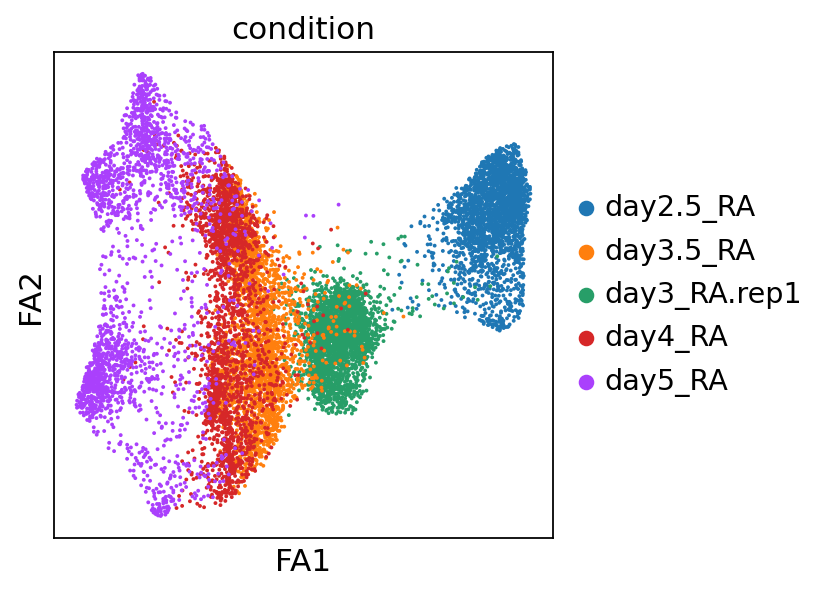

In [28]:
# generate neighbor draph in multiscale diffusion space
sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_seurat_pca", n_pcs = 20)
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_seurat_umap"][:,:2]
sc.tl.draw_graph(adata, init_pos='X_pca2d')
sc.pl.draw_graph(adata, color="condition",color_map="RdBu_r")

In [29]:
adata

AnnData object with n_obs × n_vars = 10000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'draw_graph', 'condition_colors'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap', 'X_palantir', 'X_pca2d', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were fo

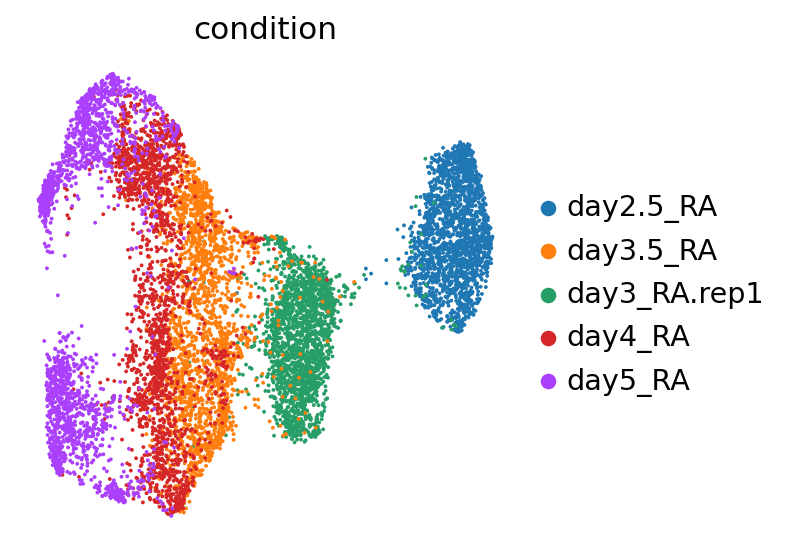

In [30]:
sc.pl.embedding(
    adata,
    basis="umap",
    color = 'condition',
    frameon=False,
)

In [33]:
# sc.pl.pca(adata, color=['condition'], components='2,3')

In [34]:
adata

AnnData object with n_obs × n_vars = 10000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'draw_graph', 'condition_colors'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap', 'X_palantir', 'X_pca2d', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [35]:
#Tree learning with SimplePPT

In [36]:
#scf.tl.tree(adata,method="ppt", Nodes=100, use_rep="umap", 
#            ndims_rep=20,
#            device="cpu",
#            seed=1,
#            ppt_lambda=200,
#            ppt_sigma=0.1,
#            ppt_nsteps=200)

inferring a principal tree --> parameters used 
    100 principal points, sigma = 0.1, lambda = 100, metric = euclidean
    fitting:   1%|          | 2/200 [00:00<00:35,  5.65it/s]
    converged


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 


    more than 30 tips detected!
    finished (0:00:00) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

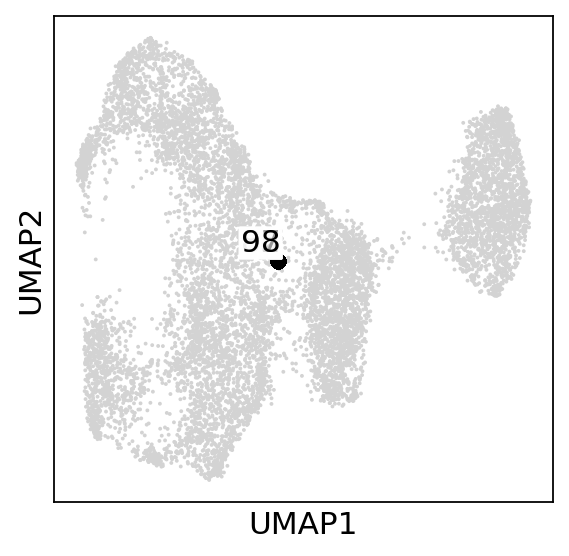

In [60]:
scf.tl.tree(adata, method="ppt", Nodes=100, use_rep="X_seurat_pca", 
            ndims_rep=30,
            device="cpu",
            seed=1,
            ppt_lambda=100,
            ppt_sigma=0.1,
            ppt_nsteps=200)
# projecting results onto ForceAtlas2 embedding
scf.pl.graph(adata, basis = 'umap')

inferring a principal tree --> parameters used 
    100 principal points, sigma = 0.6, lambda = 200, metric = euclidean
    fitting:  34%|███▍      | 68/200 [00:07<00:13,  9.48it/s]
    converged
    finished (0:00:07) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families

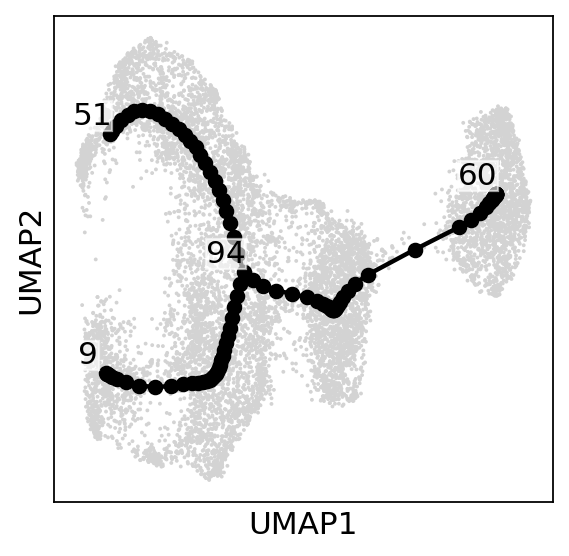

In [38]:
scf.tl.tree(adata, method="ppt", Nodes=100, use_rep="X_seurat_umap", 
            ndims_rep=20,
            device="cpu",
            seed=1,
            ppt_lambda=200,
            ppt_sigma=0.6,
            ppt_nsteps=200)

# projecting results onto ForceAtlas2 embedding
scf.pl.graph(adata, basis = 'umap')

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families

    graph cleaned --> removed 0 principal points


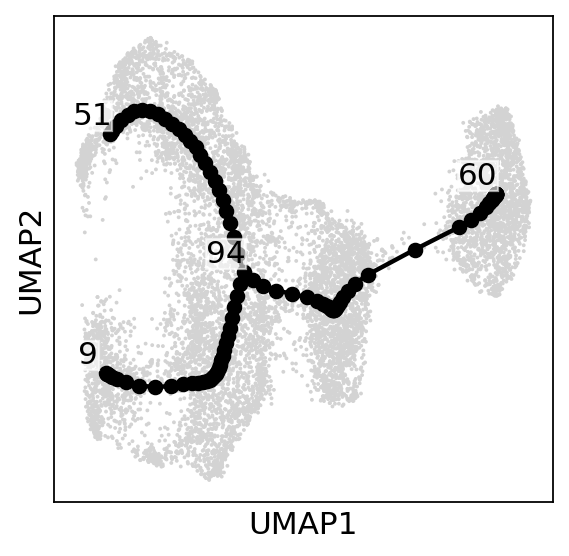

In [39]:
scf.tl.cleanup(adata,minbranchlength=10);
scf.pl.graph(adata, basis = 'umap')

In [40]:
# Selecting a root and computing pseudotime
# Using CD34 marker, we can confidently tell that the tip 163 is the root.
scf.tl.root(adata, 60)

node 60 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [41]:
# Here we are going to generate 100 mappings of pseudotime, to account for cell asssignment uncertainty. 
# to .obs will be saved the mean of all calculated pseudotimes.
# exmaple data takes > 360G memory and 16 nodes
scf.tl.pseudotime(adata, seed=42, n_jobs=20, n_map=100)

projecting cells onto the principal graph
    mappings:   0%|          | 0/100 [00:00<?, ?it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    mappings:   1%|          | 1/100 [01:09<1:54:35, 69.45s/it]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    mappings:   3%|▎         | 3/100 [01:17<41:46, 25.84s/it]  

by .GlobalEnv when processing object ‘aa’


    mappings:   4%|▍         | 4/100 [01:19<31:48, 19.88s/it]

by .GlobalEnv when processing object ‘aa’


    mappings: 100%|██████████| 100/100 [02:11<00:00,  1.32s/it]
    finished (0:02:17) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


In [42]:
adata

AnnData object with n_obs × n_vars = 10000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'draw_graph', 'condition_colors', 'graph', 'ppt', 'pseudotime_list', 'milestones_colors', 'seg_colors'
    obsm: 'X_pca', 'X_umap', 'X_seurat_pca', 'X_seurat_umap', 'X_palantir', 'X_pca2d', 'X_draw_graph_fa', 'X_R'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [43]:
# save the intermediate file, that takes long time to compute
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5.h5ad'), compression="gzip")

In [44]:
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5.h5ad'),chunk_size=6000)

In [45]:
adata

AnnData object with n_obs × n_vars = 10000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'condition_colors', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors'
    obsm: 'X_R', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families

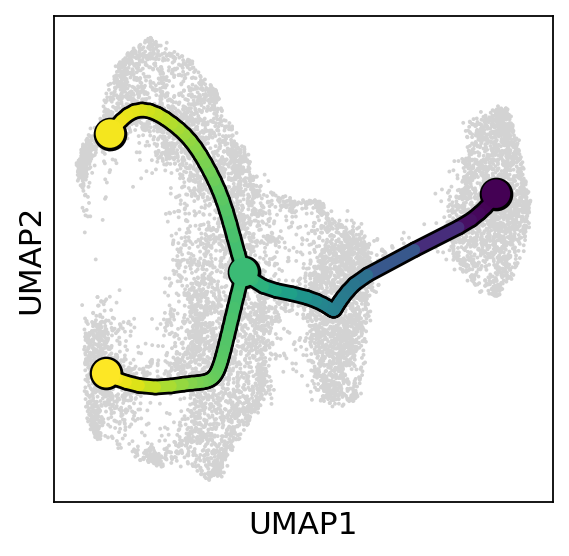

In [46]:
# Representing the trajectory and tree on top of existing embedding
scf.pl.trajectory(adata, basis = 'umap')

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' 

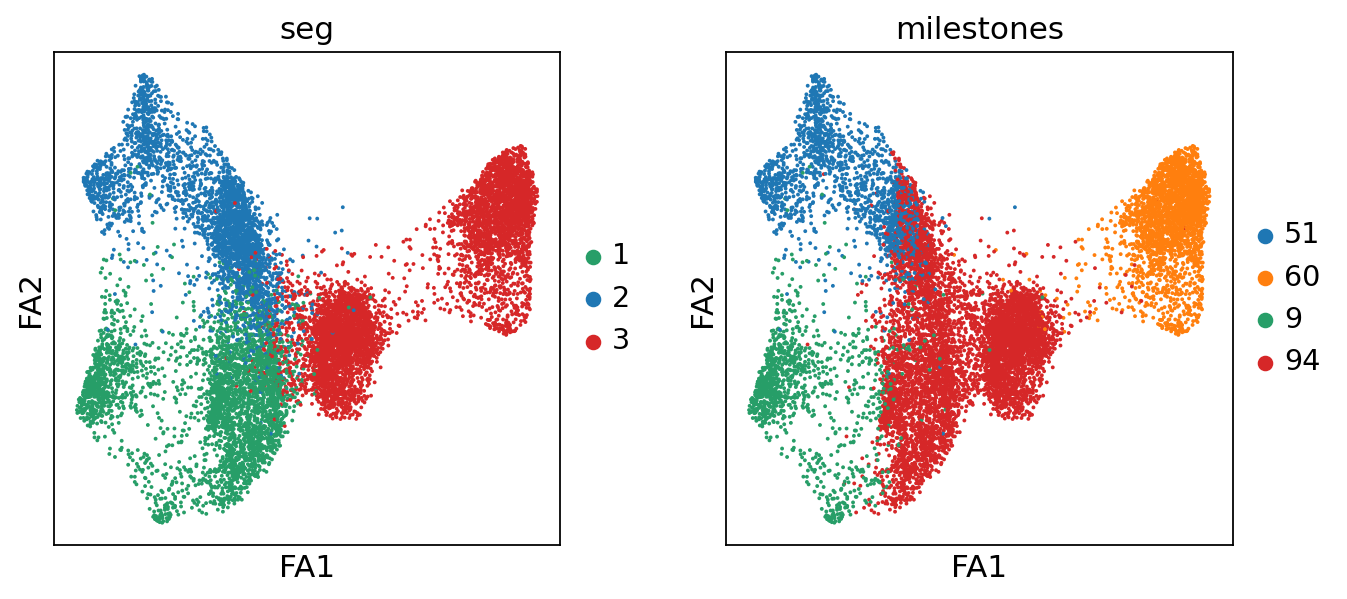

In [47]:
sc.pl.draw_graph(adata,color=["seg","milestones"])

findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

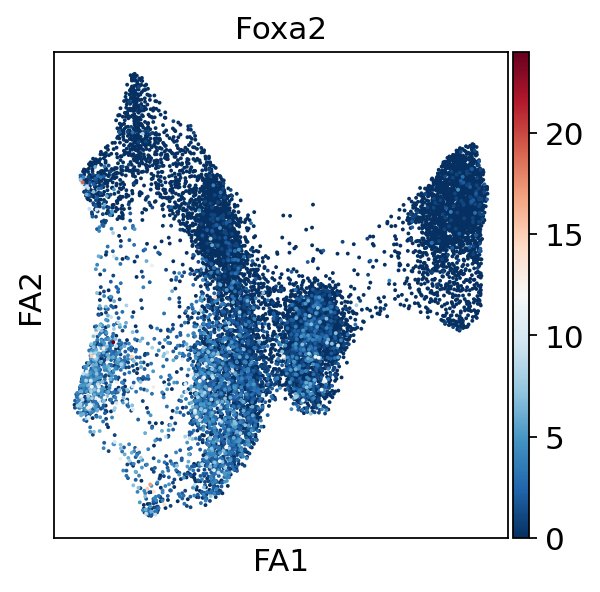

In [48]:
sc.pl.draw_graph(adata,color="Foxa2",color_map="RdBu_r")

In [49]:
scf.tl.rename_milestones(adata,["NP", "Root","FP", "Bifu"])
# we change the color of the root milestone for better visualisations
adata.uns["milestones_colors"][3]="#17bece"

In [50]:
from pathlib import Path
Path(os.path.join(outDir, "figures/")).mkdir(parents=True, exist_ok=True)

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


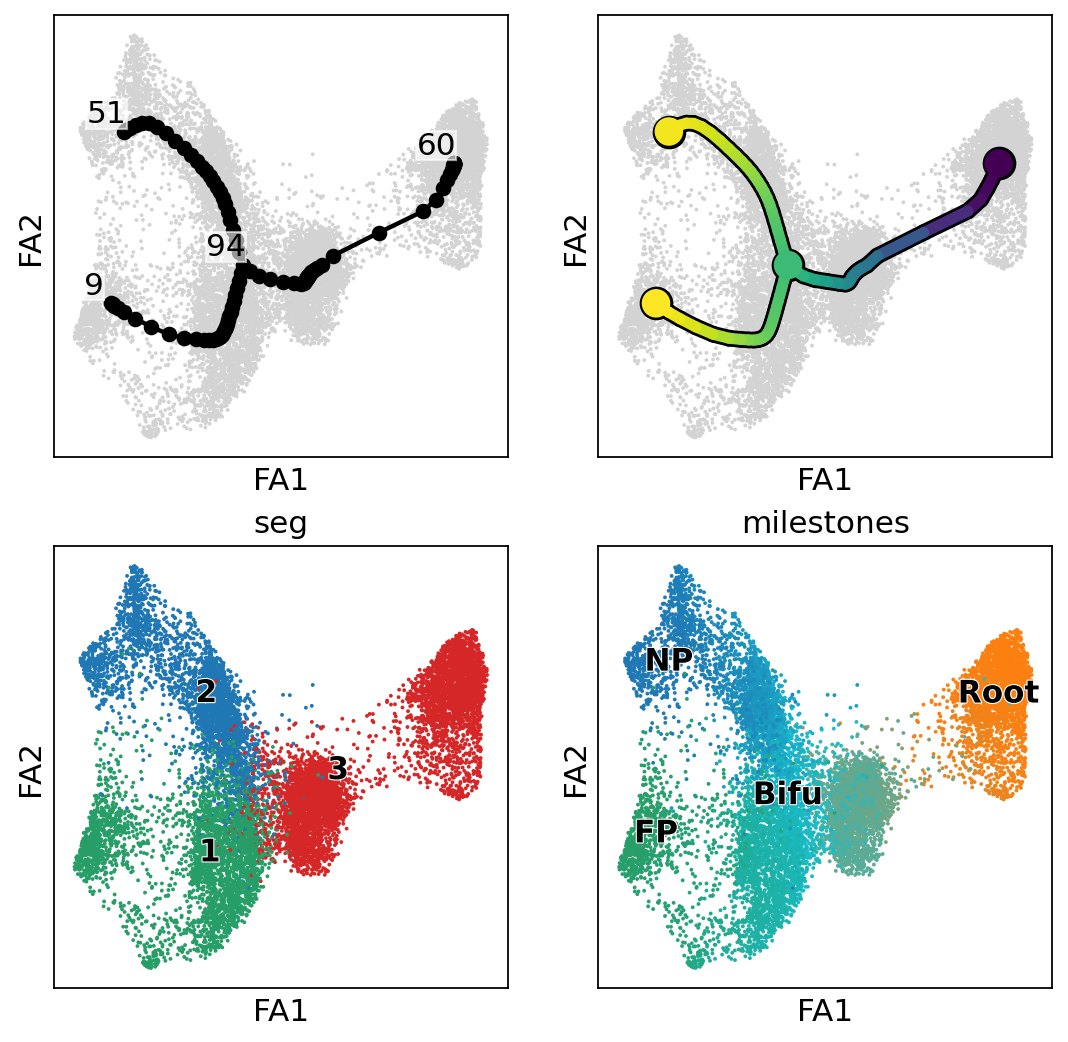

In [51]:
sc.set_figure_params()
fig, axs=plt.subplots(2,2,figsize=(8,8))
axs=axs.ravel()
scf.pl.graph(adata,basis="draw_graph_fa",show=False,ax=axs[0])
scf.pl.trajectory(adata,basis="draw_graph_fa",show=False,ax=axs[1])
sc.pl.draw_graph(adata,color=["seg"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)
scf.pl.milestones(adata,ax=axs[3],show=False,annotate=True)
plt.savefig(os.path.join(outDir, "figures/A.pdf"),dpi=300)

In [52]:
# as a dendrogram representation (take some 5-10 minutes)
scf.tl.dendrogram(adata)

Generating dendrogram of tree
    segment : 100%|██████████| 3/3 [01:42<00:00, 34.05s/it]
    finished (0:01:42) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were fo

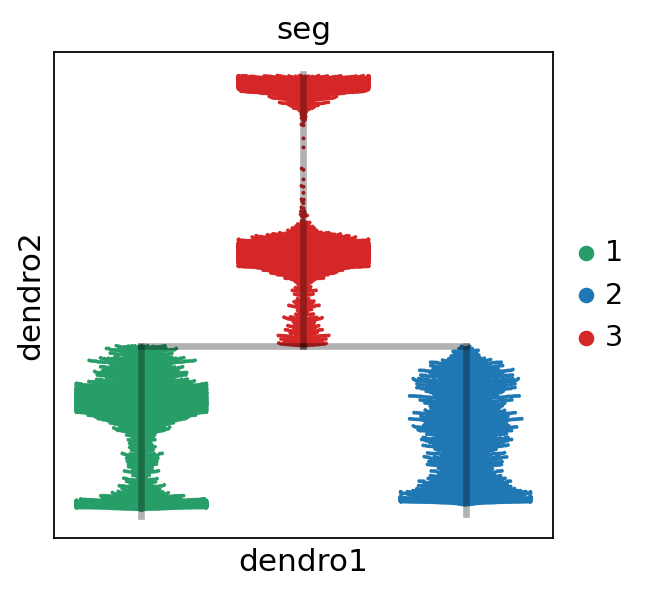

In [53]:
scf.pl.dendrogram(adata,color="seg")

findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

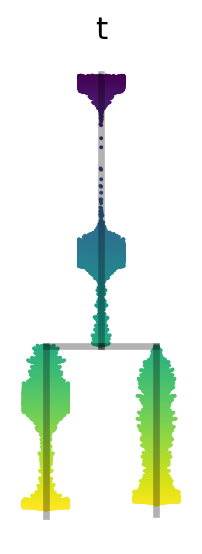

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Generic family 'serif' not found because

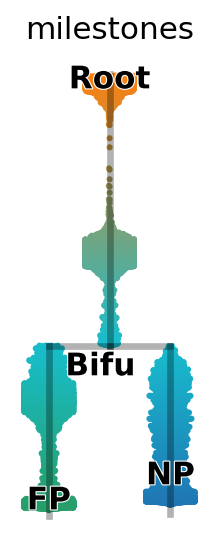

In [54]:
sc.set_figure_params(figsize=(1.5,4),frameon=False,dpi_save=300)
scf.pl.dendrogram(adata,color="t",show_info=False,
                  save="B1.pdf",
                  cmap="viridis")
scf.pl.dendrogram(adata,color="milestones",legend_loc="on data",
                  color_milestones=True,legend_fontoutline=True, 
                  save="B2.pdf")


In [55]:
# save the intermediate file, that takes long time to compute
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_before.test.asssociation.h5ad'), compression="gzip")

In [96]:
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_before.test.asssociation.h5ad'),chunk_size=6000)

In [97]:
# Test and fit features associated with the tree
scf.tl.test_association(adata,n_jobs=20, A_cut=0.5)

test features for association with the trajectory
    single mapping :   6%|▌         | 118/2001 [00:07<02:03, 15.23it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   6%|▌         | 119/2001 [00:13<03:34,  8.79it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   6%|▋         | 127/2001 [00:17<04:22,  7.13it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   6%|▋         | 129/2001 [00:22<05:24,  5.77it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   7%|▋         | 134/2001 [00:29<06:44,  4.61it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   7%|▋         | 135/2001 [00:35<08:17,  3.75it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   7%|▋         | 138/2001 [00:44<09:58,  3.11it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   7%|▋         | 140/2001 [00:51<11:23,  2.72it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   7%|▋         | 148/2001 [00:57<11:57,  2.58it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   8%|▊         | 153/2001 [01:02<12:33,  2.45it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   8%|▊         | 167/2001 [01:10<12:49,  2.38it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   8%|▊         | 169/2001 [01:15<13:38,  2.24it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   9%|▊         | 171/2001 [01:20<14:20,  2.13it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   9%|▊         | 173/2001 [01:26<15:11,  2.01it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   9%|▊         | 175/2001 [01:34<16:24,  1.85it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   9%|▉         | 176/2001 [01:46<18:20,  1.66it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :   9%|▉         | 177/2001 [01:46<18:13,  1.67it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :   9%|▉         | 180/2001 [01:53<19:05,  1.59it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can b

    single mapping :  10%|█         | 203/2001 [02:10<19:14,  1.56it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  10%|█         | 204/2001 [02:16<19:58,  1.50it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  14%|█▍        | 284/2001 [02:28<14:55,  1.92it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  15%|█▌        | 304/2001 [02:30<13:58,  2.02it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  15%|█▌        | 310/2001 [02:35<14:10,  1.99it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  16%|█▌        | 312/2001 [02:40<14:31,  1.94it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  16%|█▌        | 316/2001 [02:45<14:43,  1.91it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  16%|█▌        | 319/2001 [02:52<15:08,  1.85it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  16%|█▌        | 320/2001 [02:57<15:34,  1.80it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’


    single mapping :  16%|█▌        | 322/2001 [03:02<15:52,  1.76it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  16%|█▌        | 325/2001 [03:09<16:15,  1.72it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  16%|█▋        | 327/2001 [03:14<16:37,  1.68it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  16%|█▋        | 328/2001 [03:24<17:23,  1.60it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  17%|█▋        | 345/2001 [03:32<16:58,  1.63it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  18%|█▊        | 353/2001 [03:38<16:59,  1.62it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  22%|██▏       | 436/2001 [03:52<13:54,  1.88it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  23%|██▎       | 453/2001 [04:01<13:46,  1.87it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  23%|██▎       | 457/2001 [04:15<14:24,  1.79it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  23%|██▎       | 458/2001 [04:23<14:46,  1.74it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  23%|██▎       | 459/2001 [04:29<15:04,  1.71it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  23%|██▎       | 467/2001 [04:34<15:02,  1.70it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  24%|██▎       | 473/2001 [04:39<15:04,  1.69it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or 

    single mapping :  24%|██▍       | 477/2001 [05:01<16:02,  1.58it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  25%|██▍       | 499/2001 [05:07<15:24,  1.63it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  27%|██▋       | 531/2001 [05:14<14:30,  1.69it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  27%|██▋       | 547/2001 [05:16<14:02,  1.73it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  29%|██▊       | 572/2001 [05:26<13:34,  1.75it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  29%|██▉       | 578/2001 [05:32<13:38,  1.74it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  30%|██▉       | 599/2001 [05:38<13:11,  1.77it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  30%|██▉       | 600/2001 [05:43<13:22,  1.75it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  30%|███       | 604/2001 [05:49<13:27,  1.73it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/jobli

    single mapping :  31%|███       | 617/2001 [06:09<13:49,  1.67it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  31%|███       | 622/2001 [06:15<13:52,  1.66it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  31%|███▏      | 630/2001 [06:21<13:50,  1.65it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  32%|███▏      | 634/2001 [06:27<13:55,  1.64it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  32%|███▏      | 648/2001 [06:33<13:42,  1.65it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  34%|███▍      | 680/2001 [06:40<12:58,  1.70it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  36%|███▌      | 720/2001 [06:49<12:08,  1.76it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’


    single mapping :  36%|███▌      | 723/2001 [06:55<12:14,  1.74it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  36%|███▋      | 730/2001 [07:03<12:17,  1.72it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  37%|███▋      | 731/2001 [07:10<12:27,  1.70it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  37%|███▋      | 743/2001 [07:22<12:28,  1.68it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  37%|███▋      | 747/2001 [07:29<12:33,  1.66it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  37%|███▋      | 748/2001 [07:36<12:44,  1.64it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  38%|███▊      | 752/2001 [07:44<12:50,  1.62it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  38%|███▊      | 756/2001 [07:52<12:57,  1.60it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  41%|████▏     | 826/2001 [08:03<11:27,  1.71it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  42%|████▏     | 833/2001 [08:08<11:25,  1.71it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  42%|████▏     | 849/2001 [08:16<11:13,  1.71it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  43%|████▎     | 855/2001 [08:22<11:13,  1.70it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  43%|████▎     | 862/2001 [08:29<11:13,  1.69it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  44%|████▍     | 876/2001 [08:36<11:02,  1.70it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  44%|████▍     | 885/2001 [08:44<11:01,  1.69it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  44%|████▍     | 886/2001 [08:52<11:09,  1.66it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  45%|████▍     | 894/2001 [08:58<11:06,  1.66it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  45%|████▍     | 898/2001 [09:03<11:07,  1.65it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  45%|████▌     | 903/2001 [09:12<11:12,  1.63it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  45%|████▌     | 910/2001 [09:18<11:09,  1.63it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  46%|████▌     | 914/2001 [09:26<11:13,  1.61it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  47%|████▋     | 931/2001 [09:32<10:57,  1.63it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  47%|████▋     | 940/2001 [09:40<10:55,  1.62it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  50%|█████     | 1010/2001 [09:51<09:40,  1.71it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  51%|█████     | 1020/2001 [09:59<09:36,  1.70it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  51%|█████     | 1025/2001 [10:12<09:43,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  51%|█████▏    | 1027/2001 [10:20<09:48,  1.65it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  52%|█████▏    | 1031/2001 [10:25<09:48,  1.65it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  52%|█████▏    | 1035/2001 [10:33<09:50,  1.63it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  52%|█████▏    | 1037/2001 [10:39<09:54,  1.62it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’


    single mapping :  52%|█████▏    | 1045/2001 [10:55<09:59,  1.59it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  53%|█████▎    | 1062/2001 [11:09<09:51,  1.59it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  55%|█████▌    | 1102/2001 [11:16<09:12,  1.63it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  57%|█████▋    | 1140/2001 [11:21<08:34,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  58%|█████▊    | 1157/2001 [11:28<08:22,  1.68it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  58%|█████▊    | 1163/2001 [11:35<08:21,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  58%|█████▊    | 1169/2001 [11:43<08:20,  1.66it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some j

    single mapping :  59%|█████▊    | 1171/2001 [12:04<08:33,  1.62it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  59%|█████▉    | 1177/2001 [12:12<08:32,  1.61it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or 

    single mapping :  59%|█████▉    | 1181/2001 [12:30<08:41,  1.57it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  60%|█████▉    | 1196/2001 [12:36<08:29,  1.58it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  60%|██████    | 1205/2001 [12:42<08:23,  1.58it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  64%|██████▎   | 1274/2001 [12:53<07:21,  1.65it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  65%|██████▍   | 1292/2001 [12:55<07:05,  1.67it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  65%|██████▍   | 1298/2001 [13:05<07:05,  1.65it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  65%|██████▍   | 1299/2001 [13:11<07:07,  1.64it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  65%|██████▌   | 1302/2001 [13:19<07:09,  1.63it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  65%|██████▌   | 1304/2001 [13:36<07:16,  1.60it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  65%|██████▌   | 1307/2001 [13:42<07:16,  1.59it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  65%|██████▌   | 1308/2001 [13:47<07:18,  1.58it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  65%|██████▌   | 1310/2001 [13:53<07:19,  1.57it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  66%|██████▌   | 1311/2001 [13:58<07:21,  1.56it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  67%|██████▋   | 1331/2001 [14:04<07:04,  1.58it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  67%|██████▋   | 1338/2001 [14:10<07:01,  1.57it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  69%|██████▉   | 1379/2001 [14:17<06:26,  1.61it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping :  71%|███████   | 1422/2001 [14:22<05:51,  1.65it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  71%|███████▏  | 1427/2001 [14:30<05:50,  1.64it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’


    single mapping :  72%|███████▏  | 1432/2001 [14:43<05:51,  1.62it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’


    single mapping :  72%|███████▏  | 1435/2001 [14:50<05:51,  1.61it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  72%|███████▏  | 1441/2001 [15:05<05:51,  1.59it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’


    single mapping :  72%|███████▏  | 1443/2001 [15:19<05:55,  1.57it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  72%|███████▏  | 1444/2001 [15:33<06:00,  1.55it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  73%|███████▎  | 1457/2001 [15:38<05:50,  1.55it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  75%|███████▍  | 1491/2001 [15:48<05:24,  1.57it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  78%|███████▊  | 1554/2001 [16:02<04:36,  1.62it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  78%|███████▊  | 1569/2001 [16:11<04:27,  1.62it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  79%|███████▉  | 1577/2001 [16:17<04:22,  1.61it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  79%|███████▉  | 1580/2001 [16:24<04:22,  1.60it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  79%|███████▉  | 1584/2001 [16:30<04:20,  1.60it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  79%|███████▉  | 1585/2001 [16:36<04:21,  1.59it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  79%|███████▉  | 1586/2001 [16:43<04:22,  1.58it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  79%|███████▉  | 1589/2001 [16:48<04:21,  1.58it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  80%|███████▉  | 1591/2001 [17:01<04:23,  1.56it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  80%|███████▉  | 1599/2001 [17:12<04:19,  1.55it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  82%|████████▏ | 1634/2001 [17:20<03:53,  1.57it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  83%|████████▎ | 1659/2001 [17:26<03:35,  1.59it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  85%|████████▌ | 1708/2001 [17:36<03:01,  1.62it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  86%|████████▌ | 1718/2001 [17:43<02:55,  1.62it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  86%|████████▌ | 1719/2001 [17:57<02:56,  1.60it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  86%|████████▌ | 1725/2001 [18:03<02:53,  1.59it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  87%|████████▋ | 1731/2001 [18:16<02:51,  1.58it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  87%|████████▋ | 1733/2001 [18:22<02:50,  1.57it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  87%|████████▋ | 1735/2001 [18:27<02:49,  1.57it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  87%|████████▋ | 1739/2001 [18:34<02:47,  1.56it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  87%|████████▋ | 1742/2001 [18:41<02:46,  1.55it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  91%|█████████▏| 1829/2001 [18:53<01:46,  1.61it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  92%|█████████▏| 1838/2001 [18:59<01:41,  1.61it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  92%|█████████▏| 1840/2001 [19:06<01:40,  1.61it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  92%|█████████▏| 1846/2001 [19:12<01:36,  1.60it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  93%|█████████▎| 1860/2001 [19:18<01:27,  1.60it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  93%|█████████▎| 1867/2001 [19:26<01:23,  1.60it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  93%|█████████▎| 1868/2001 [19:32<01:23,  1.59it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  93%|█████████▎| 1869/2001 [19:38<01:23,  1.59it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  94%|█████████▎| 1872/2001 [19:46<01:21,  1.58it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  94%|█████████▎| 1873/2001 [19:54<01:21,  1.57it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  94%|█████████▍| 1878/2001 [19:59<01:18,  1.57it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  95%|█████████▍| 1895/2001 [20:07<01:07,  1.57it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  95%|█████████▌| 1901/2001 [20:13<01:03,  1.57it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  97%|█████████▋| 1941/2001 [20:23<00:37,  1.59it/s]

by .GlobalEnv when processing object ‘aa’
/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping :  99%|█████████▉| 1979/2001 [20:33<00:13,  1.60it/s]

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scFates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    single mapping : 100%|█████████▉| 1992/2001 [20:41<00:05,  1.60it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    single mapping : 100%|█████████▉| 1998/2001 [21:04<00:01,  1.58it/s]

by .GlobalEnv when processing object ‘aa’
by .GlobalEnv when processing object ‘aa’


    single mapping : 100%|█████████▉| 2000/2001 [21:14<00:00,  1.57it/s]

by .GlobalEnv when processing object ‘aa’


    single mapping : 100%|██████████| 2001/2001 [21:25<00:00,  1.56it/s]
    found 190 significant features (0:21:25) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [99]:
# save the intermediate file, that takes long time to compute
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_after.test.asssociation_v4.h5ad'), compression="gzip")

In [12]:
#adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_after.test.asssociation_v4.h5ad'),chunk_size=6000)
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d3_d5_after.test.asssociation_v4.h5ad'),chunk_size=6000)

In [13]:
outDir 

'../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d2.5_d5_TFs_SPs_regressed.CellCycle_v1/'

In [14]:
#outDir = "../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d2.5_d6_noMatureNeuron_filteredCellCycleGenes_v1.2/"
sc.settings.figdir = os.path.join(outDir, "figures/")

In [15]:
adata

AnnData object with n_obs × n_vars = 10000 × 2001
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

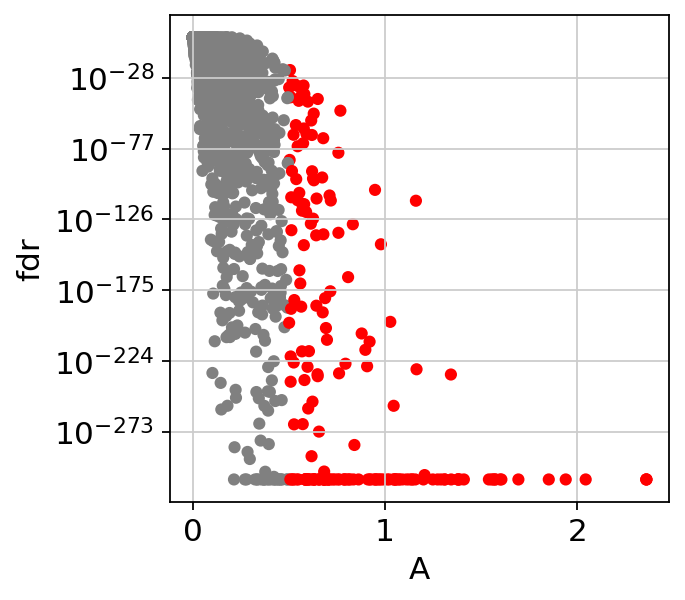

In [16]:
sc.set_figure_params()
scf.pl.test_association(adata)
plt.savefig("figures/C_v2.pdf",dpi=300)

In [33]:
scf.tl.fit(adata, n_jobs=20, gamma = 50)

fit features associated with the trajectory
    single mapping : 100%|██████████| 190/190 [00:16<00:00, 11.67it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:16) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

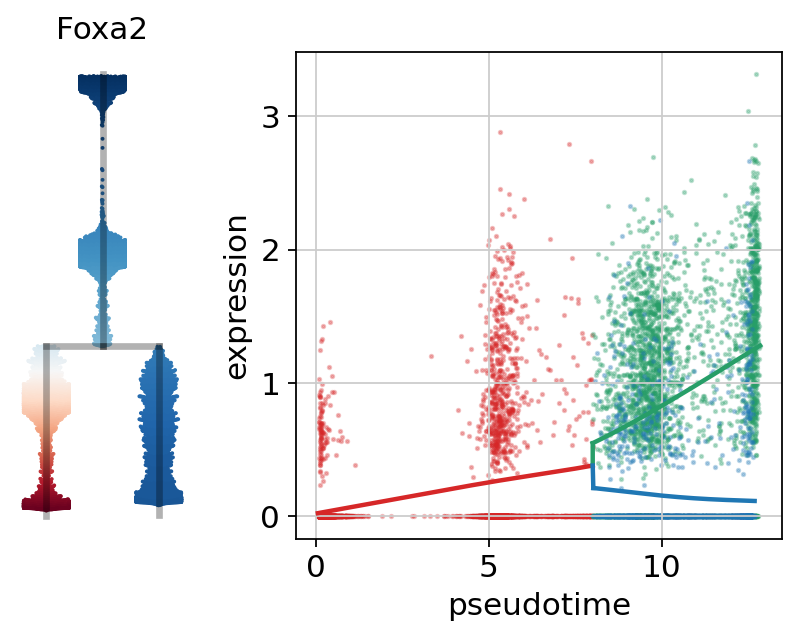

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

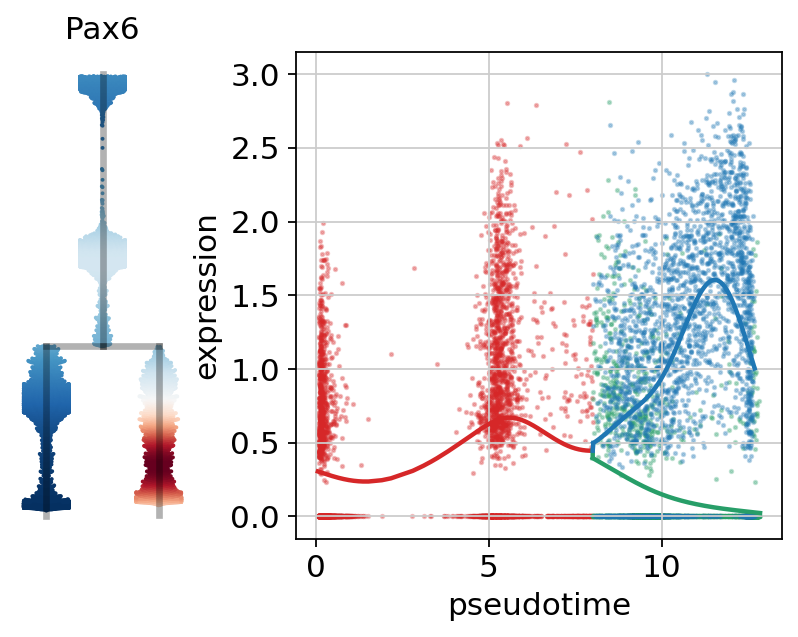

In [31]:
# Plotting single features
sc.set_figure_params(figsize=(.8,4),frameon=False)
scf.set_figure_pubready()
scf.pl.single_trend(adata,"Foxa2",basis="dendro",wspace=-.25,save="_E1.pdf")
scf.pl.single_trend(adata,"Pax6",basis="dendro",wspace=-.25,save="_E2.pdf")

In [34]:
outDir

'../results/scRNAseq_R13547_10x_mNT_20220813/RA_symetryBreaking/TF_modules/d2.5_d5_TFs_SPs_regressed.CellCycle_v1/'

In [35]:
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d2_d5_after.test.asssociation_v4_trajectory_fit.h5ad'), compression="gzip")

In [12]:
adata = sc.read_h5ad(os.path.join(outDir,'scFates_pseudotime_mNT_d2_d5_after.test.asssociation_v4_trajectory_fit.h5ad'),chunk_size=6000)

In [13]:
adata.layers["fitted"]

array([[ 1.06430026e-01,  3.15382847e-01,  1.31106822e+00, ...,
        -2.37356774e-03,  1.25999774e-03,  6.23443833e-04],
       [ 1.05430960e-01,  3.16112311e-01,  1.31471275e+00, ...,
        -2.37772062e-03,  1.13348710e-03,  5.79972729e-04],
       [ 1.15143569e-01,  3.09048228e-01,  1.27942472e+00, ...,
        -2.33633333e-03,  2.19079082e-03,  1.00155972e-03],
       ...,
       [ 2.89901157e-02,  6.91162692e-02,  5.08352366e-01, ...,
         1.63107480e-01, -1.60102905e-02,  1.31491037e-03],
       [-3.31761776e-02,  3.86881077e-02,  4.71660673e-01, ...,
         2.07117859e-01,  4.45471482e-01,  1.31491041e-03],
       [ 9.04878718e-02,  9.76368536e-02,  5.45166305e-01, ...,
         1.19605104e-01,  3.07447697e-02,  1.31491033e-03]])

In [14]:
adata

AnnData object with n_obs × n_vars = 10000 × 190
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [40]:
# All branches DE analysis
scf.tl.test_fork(adata,root_milestone="Root",milestones=["NP","FP"],n_jobs=20, rescale=True)

testing fork
    single mapping
    Differential expression: 100%|██████████| 190/190 [00:08<00:00, 23.52it/s]
    test for upregulation for each leave vs root
    upreg FP: 100%|██████████| 109/109 [00:00<00:00, 290.71it/s]
    finished (0:00:09) --> added 
    .uns['Root->NP<>FP']['fork'], DataFrame with fork test results.


In [41]:
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d2_d5_after.test.asssociation_trajectory_fit_testFork_v4.h5ad'), compression="gzip")

In [42]:
# Bifurcation analysis

In [9]:
adata = sc.read_h5ad(os.path.join(outDir, 'scFates_pseudotime_mNT_d2_d5_after.test.asssociation_trajectory_fit_testFork_v4.h5ad'),chunk_size=6000)

In [10]:
# test the thresholding parameters
effect = 0.25
scf.tl.branch_specific(adata,root_milestone="Root", milestones=["NP","FP"], effect= effect, copy = True)
#scf.tl.branch_specific(adata,root_milestone="Root",milestones=["NP", "FP"], effect=0.2)

    branch specific features: FP: 22, NP: 20
    finished --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'branch' column.


AnnData object with n_obs × n_vars = 10000 × 190
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [11]:
scf.tl.branch_specific(adata,root_milestone="Root",milestones=["NP", "FP"], effect= effect)

    branch specific features: FP: 22, NP: 20
    finished --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'branch' column.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

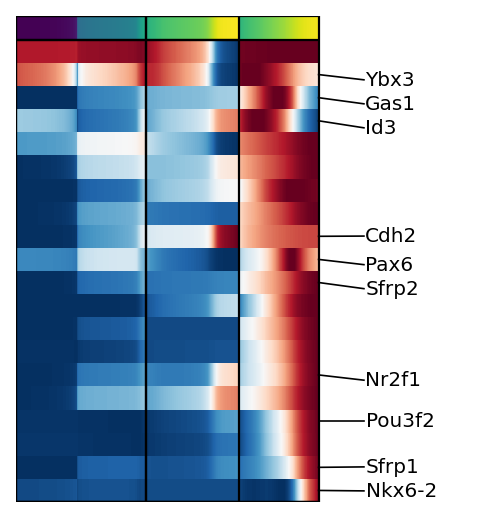

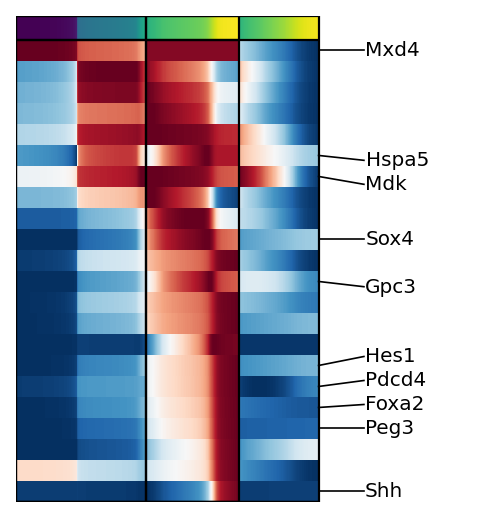

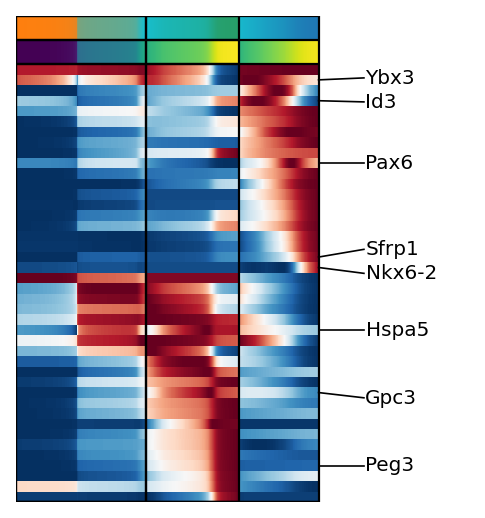

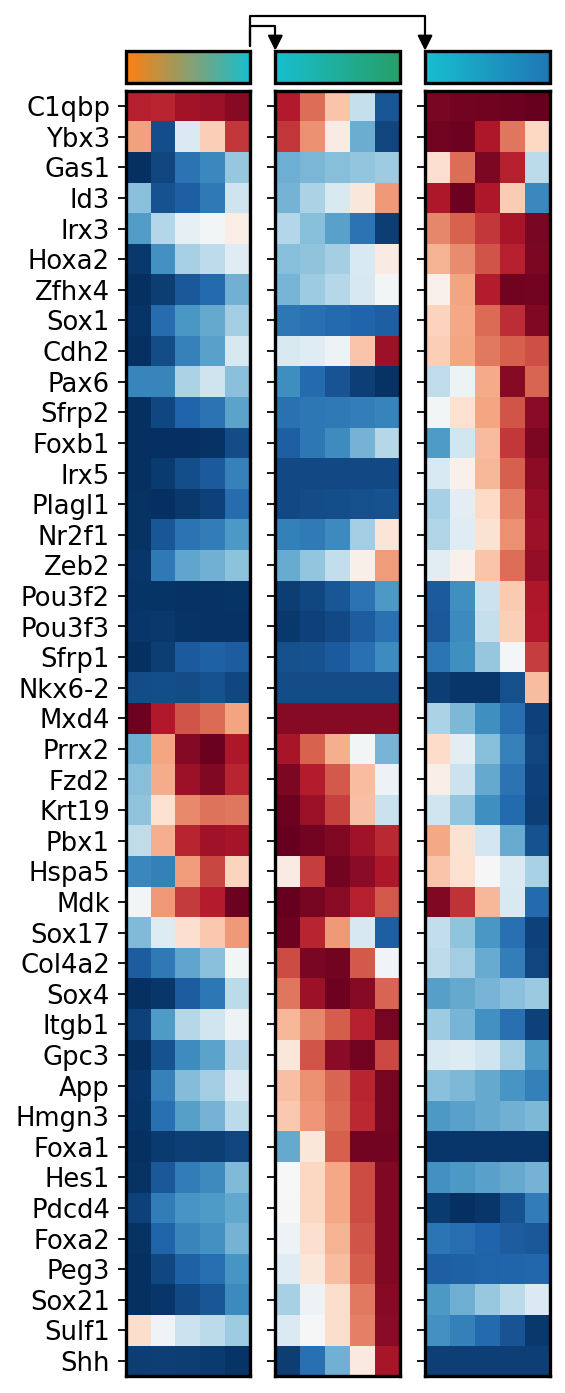

In [12]:
g1=scf.pl.trends(adata,
                 root_milestone="Root",
                 milestones=["NP","FP"],
                 branch="NP",
                 plot_emb=False,ordering="max",return_genes=True);
g2=scf.pl.trends(adata,
                 root_milestone="Root",
                 milestones=["NP", "FP"],
                 branch="FP",
                 plot_emb=False,ordering="max",return_genes=True);
gg=g1.tolist() + g2.tolist();
import matplotlib.pyplot as plt
g=scf.pl.trends(adata,gg,figsize=(4,4),annot="milestones",n_features=8,
        plot_emb=False,ordering=None,return_genes=True)
plt.savefig("figures/D.pdf",dpi=300);
# Displaying results using matrix plot
sc.set_figure_params()
scf.pl.matrix(adata,gg,norm="minmax",cmap="RdBu_r",colorbar=False,save="_F.pdf")

In [13]:
# Early gene detection

In [15]:
#scf.tl.activation_lm(adata,root_milestone="Root", milestones=["NP", "FP"], n_jobs=20)
scf.tl.activation_lm(adata, root_milestone="Root", milestones=["NP", "FP"], 
                     fdr_cut= 0.1,
                     #stf_cut = 0.8,
                     n_jobs = 20,
                     pseudotime_offset = 3.0,
                     copy = True
                    )

    single mapping
    prefork activation: 100%|██████████| 42/42 [00:00<00:00, 398.17it/s]
    9 early and 11 late features specific to leave NP
    18 early and 4 late features specific to leave FP
    finished (0:00:00) --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'slope','pval','fdr','prefork_signi' and 'module' columns.


AnnData object with n_obs × n_vars = 10000 × 190
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [16]:
scf.tl.activation_lm(adata, root_milestone="Root", milestones=["NP", "FP"], 
                     #fdr_cut= 0.5, 
                     pseudotime_offset = 3.0,
                     #stf_cut = 0.5,
                     n_jobs = 20,
                     copy = False
                    )

    single mapping
    prefork activation: 100%|██████████| 42/42 [00:00<00:00, 433.33it/s]
    8 early and 12 late features specific to leave NP
    18 early and 4 late features specific to leave FP
    finished (0:00:00) --> updated 
    .uns['Root->NP<>FP']['fork'], DataFrame updated with additionnal 'slope','pval','fdr','prefork_signi' and 'module' columns.


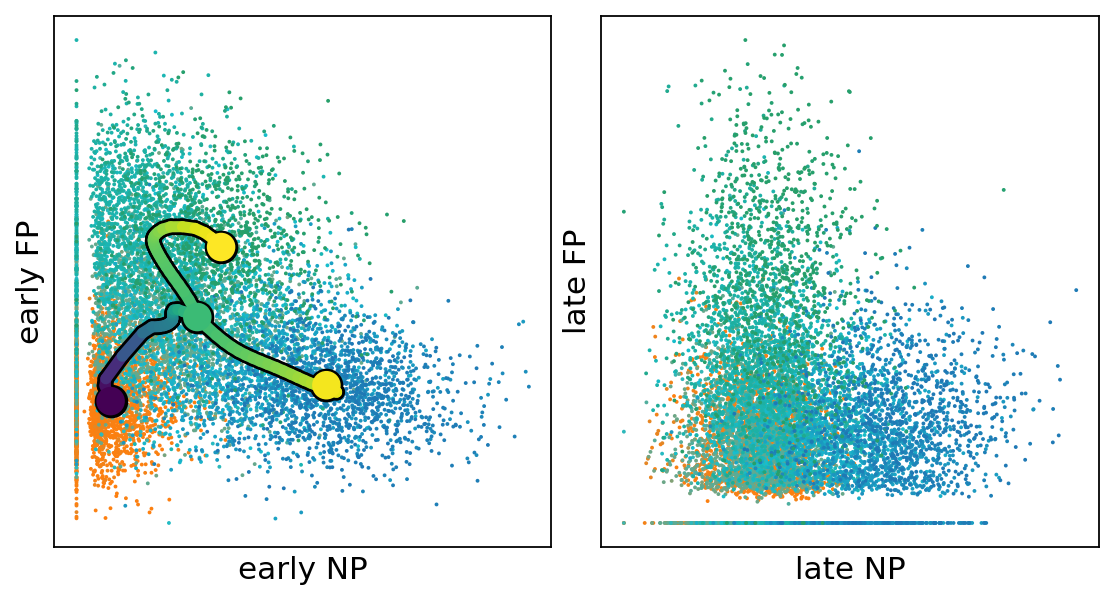

In [17]:
scf.pl.modules(adata, root_milestone="Root", milestones=["NP", "FP"],
               smooth=False, show_traj = True, module="all",save="_G_v3.pdf")

In [18]:
# extract the early and late modules
df=adata.uns["Root->NP<>FP"]["fork"].copy()
#df.index="\textit{"+df.index+"}"
eFP=df.index[(df.module=="early") & (df.branch=="FP")]
lFP=df.index[(df.module=="late") & (df.branch=="FP")]
eNP=df.index[(df.module=="early") & (df.branch=="NP")]
lNP=df.index[(df.module=="late") & (df.branch=="NP")]
import pandas as pd
dat=pd.DataFrame({'early FP': pd.Series(eFP), 
                  'late FP': pd.Series(lFP),
                  'early NP': pd.Series(eNP),
                  'late NP': pd.Series(lNP)})
dat=dat.fillna('')
dat

early FP late FP early NP late NP
0     Sox17   Sulf1     Zeb2  Pou3f3
1      Pbx1   Sox21     Pax6   Zfhx4
2     Prrx2    Sox4    Sfrp1   Sfrp2
3     Hspa5     Shh     Irx3  Pou3f2
4       Mdk             Gas1     Id3
5     Foxa2            Nr2f1    Ybx3
6      Gpc3             Cdh2  Nkx6-2
7      Mxd4            Hoxa2  Plagl1
8      Peg3                     Sox1
9    Col4a2                     Irx5
10    Itgb1                    Foxb1
11    Hmgn3                    C1qbp
12    Krt19                         
13     Fzd2                         
14    Foxa1                         
15     Hes1                         
16      App                         
17    Pdcd4

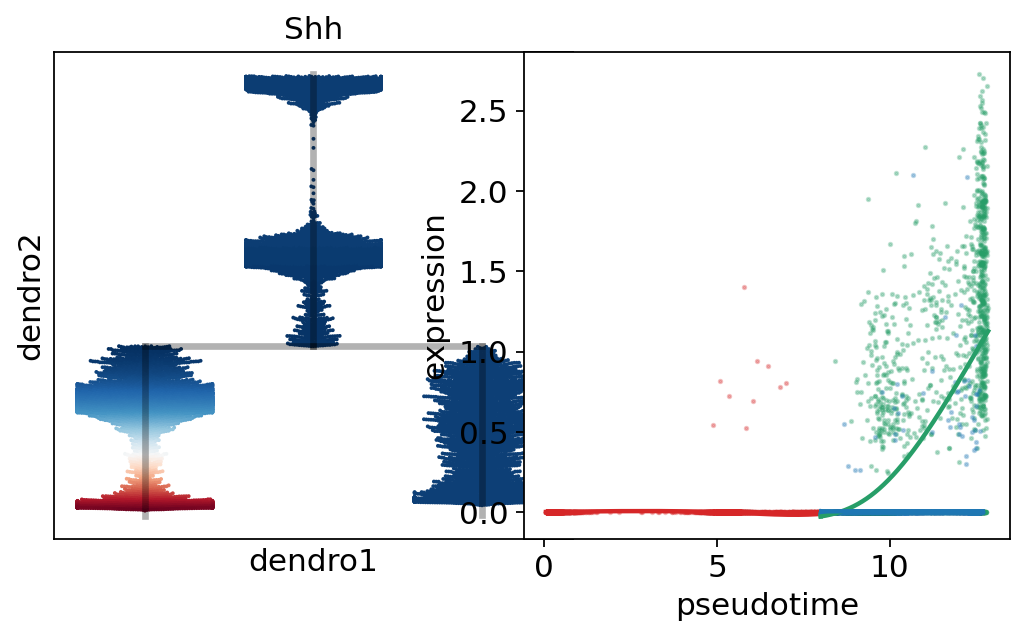

In [19]:
scf.pl.single_trend(adata,"Shh",basis="dendro",wspace=-.25)

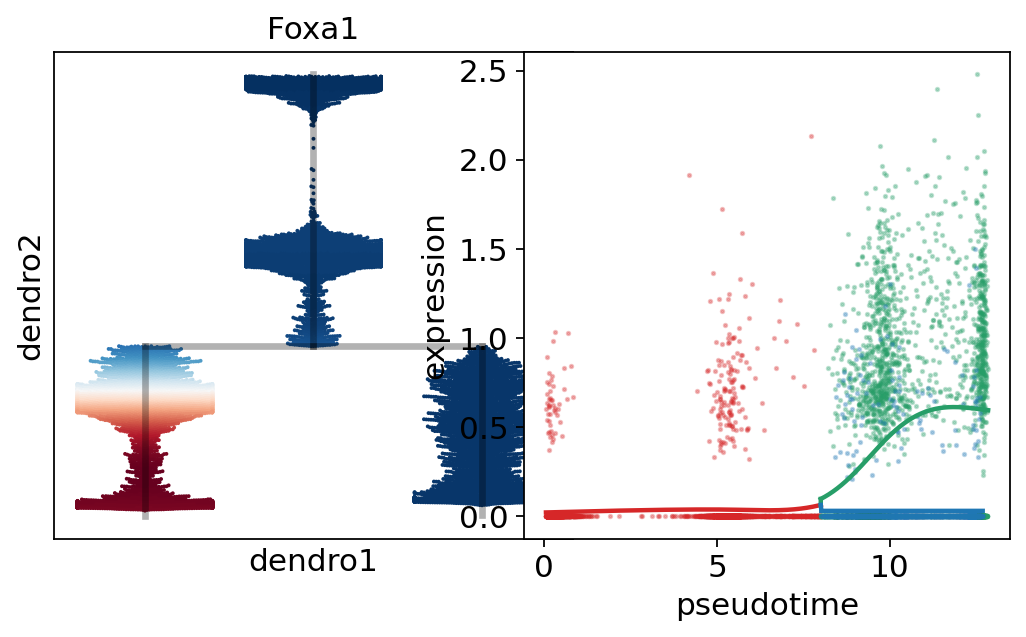

In [20]:
scf.pl.single_trend(adata,"Foxa1",basis="dendro",wspace=-.25)

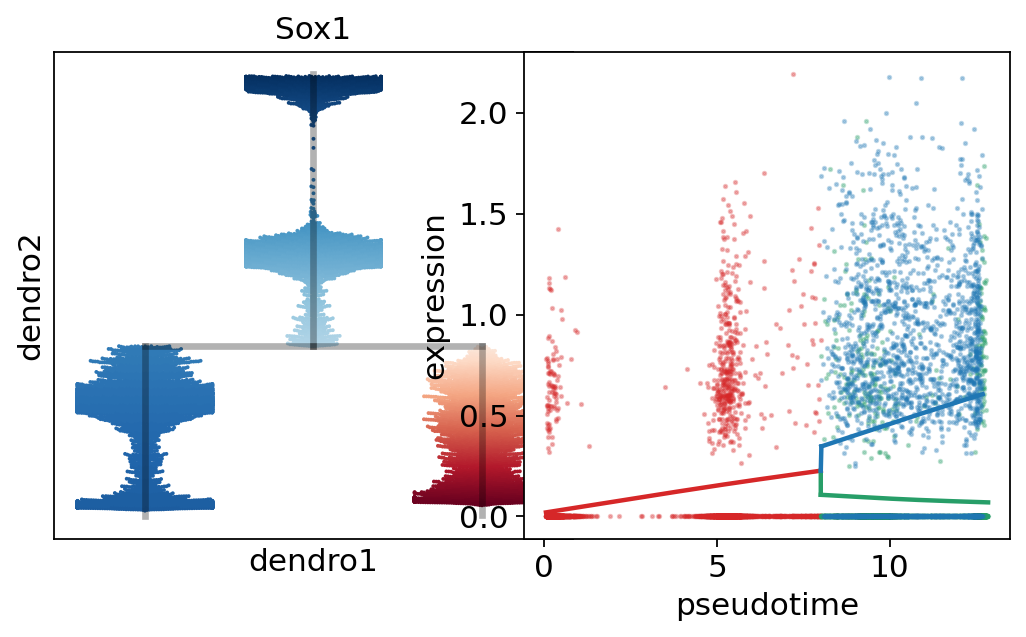

In [21]:
scf.pl.single_trend(adata,"Sox1",basis="dendro",wspace=-.25)

In [27]:
dat.to_csv(os.path.join(outDir, 'scFates_early_late_modules_NP_FP_tl.test.fork.rescaled_v4.csv'))
#with open(os.path.join(outDir + "scFates_early_late_modules_NP_FP.txt"), 'w') as f:
#        f.write(dat)

In [22]:
# Repulsion of early gene modules
scf.tl.slide_cells(adata,root_milestone="Root",milestones=["NP", "FP"], win=1500) # win parameter: number of cell per local pseudotime window.

--> added 
    .uns['Root->NP<>FP']['cell_freq'], probability assignment of cells on 8 non intersecting windows.


In [ ]:
## dissect the correlation calculation

In [26]:
adata

AnnData object with n_obs × n_vars = 10000 × 190
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [34]:
from scipy import sparse
sparse.issparse(adata.X)

True

In [44]:
root_milestone="Root"
milestones=["NP", "FP"]
win=1500
genesetA=None
genesetB=None
perm=False
layer = None

In [45]:
graph = adata.uns["graph"]
uns_temp = adata.uns.copy()
mlsc = adata.uns["milestones_colors"].copy()
dct = graph["milestones"]
keys = np.array(list(dct.keys()))
vals = np.array(list(dct.values()))


In [46]:
leaves = list(map(lambda leave: dct[leave], milestones))
root = dct[root_milestone]
name = root_milestone + "->" + "<>".join(milestones)

In [50]:
if (genesetA is None or genesetB is None) and len(milestones) == 1:
    raise ValueError(
        "You need two list of genes when a non-bifurcating trajectory is analysed!"
    )

if genesetA is None or genesetB is None:
    bif = adata.uns[name]["fork"]

freqs = adata.uns[name]["cell_freq"]
nwin = len(freqs)


In [56]:
nwin
perm

False

In [58]:
if genesetA is None:
    genesetA = bif.index[
        (bif["branch"] == milestones[0]).values & (bif["module"] == "early").values
    ]
if genesetB is None:
    genesetB = bif.index[
        (bif["branch"] == milestones[1]).values & (bif["module"] == "early").values
    ]

genes = adata.var_names
if perm:
    genesetA = np.random.choice(genes[~genes.isin(genesetA)], len(genesetA))
    genesetB = np.random.choice(genes[~genes.isin(genesetB)], len(genesetB))

genesets = np.concatenate([genesetA, genesetB])


In [62]:
def get_X(adata, cells, genes, layer, togenelist=False):
    if layer is None:
        if sparse.issparse(adata.X):
            X = adata[cells, genes].X.A
        else:
            X = adata[cells, genes].X
    else:
        if sparse.issparse(adata.layers[layer]):
            X = adata[cells, genes].layers[layer].A
        else:
            X = adata[cells, genes].layers[layer]

    if togenelist:
        return X.T.tolist()
    else:
        return X

X = get_X(adata, adata.obs_names, genesets, layer)

X = pd.DataFrame(X, index=adata.obs_names, columns=genesets)
X_r = X.rank(axis=0)

In [78]:
def gather_cor(i, geneset):
    freq = freqs[i][adata.obs_names]
    cormat = pd.DataFrame(
        DescrStatsW(X_r.values, weights=freq).corrcoef,
        index=genesets,
        columns=genesets,
    )
    np.fill_diagonal(cormat.values, np.nan)
    return cormat.loc[:, geneset].mean(axis=1)

In [81]:
from functools import partial
from statsmodels.stats.weightstats import DescrStatsW

gather = partial(gather_cor, geneset=genesetA)
corA = pd.concat(list(map(gather, range(nwin))), axis=1)
corA.columns = [str(c) for c in corA.columns]
corA = dict(
    zip(
        ["genesetA", "genesetB"],
        [corA.loc[geneset] for geneset in [genesetA, genesetB]],
    )
)

In [83]:
df = X
df[df["Pax6"] > 0];
X_r;
partial(gather_cor, geneset=genesetA)
X_r.values

array([[5306. , 2718. , 2868.5, ..., 4239. , 2922.5, 2801. ],
       [6239.5, 6294. , 6881.5, ..., 5183.5, 2922.5, 3972. ],
       [2599.5, 2718. , 2868.5, ..., 2059.5, 2922.5, 5266. ],
       ...,
       [8202. , 9916. , 7771. , ..., 6076. , 2922.5, 6576. ],
       [9957. , 8994. , 9359. , ..., 6215. , 8241.5, 8968. ],
       [2599.5, 7951. , 9415. , ..., 4686. , 9877. , 8721. ]])

In [60]:
genesetA

Index(['Zeb2', 'Pax6', 'Sfrp1', 'Irx3', 'Gas1', 'Nr2f1', 'Cdh2', 'Hoxa2'], dtype='object')

array([[0.        , 0.43207646, 1.15114515, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.32750425, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.37190214, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.50030498, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.91174001, ..., 0.        , 0.        ,
        0.        ]])

In [23]:
scf.tl.slide_cors(adata, root_milestone="Root", milestones=["NP", "FP"])

--> added 
    .uns['Root->NP<>FP']['corAB'], gene-gene correlation modules.


In [24]:
#adata.uns['Root->NP<>FP']['corAB']

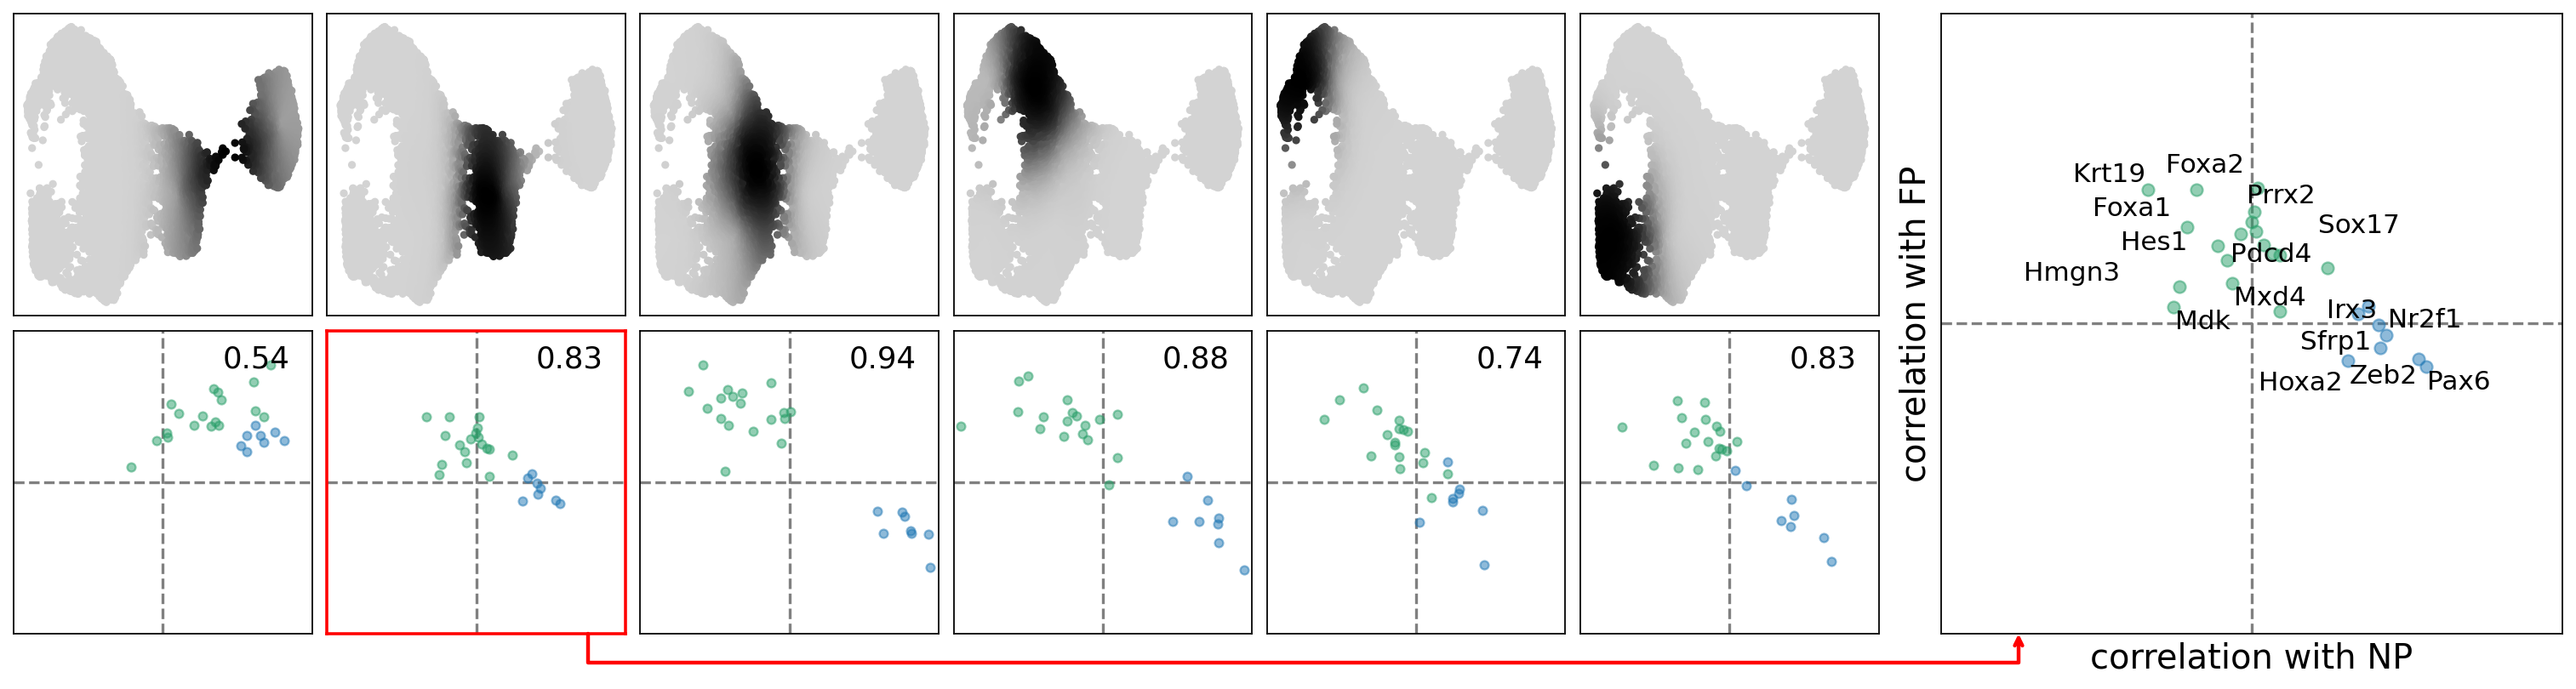

In [25]:
sc.set_figure_params()
scf.pl.slide_cors(adata,root_milestone="Root",milestones=["NP", "FP"],basis="umap", 
                 win_keep=[1, 2, 3, 4, 5,7],
                 focus=1, 
                  top_focus = 10, 
                  save="_H_save_v1.pdf")

In [ ]:
## save the outputs for customized analysis

In [37]:
adata.write(os.path.join(outDir,'scFates_pseudotime_mNT_d2_d5_localCorrelation_modules.h5ad'), compression="gzip")

In [35]:
adata = sc.read_h5ad(os.path.join(outDir, 'scFates_pseudotime_mNT_d2_d5_localCorrelation_modules.h5ad'),chunk_size=6000)

In [36]:
# Repulsion of early gene modules
scf.tl.slide_cells(adata,root_milestone="Root",milestones=["NP", "FP"], win=1500) # win parameter: number of cell per local pseudotime window.

--> added 
    .uns['Root->NP<>FP']['cell_freq'], probability assignment of cells on 8 non intersecting windows.


In [37]:
scf.tl.slide_cors(adata,root_milestone="Root",milestones=["NP", "FP"])

--> added 
    .uns['Root->NP<>FP']['corAB'], gene-gene correlation modules.


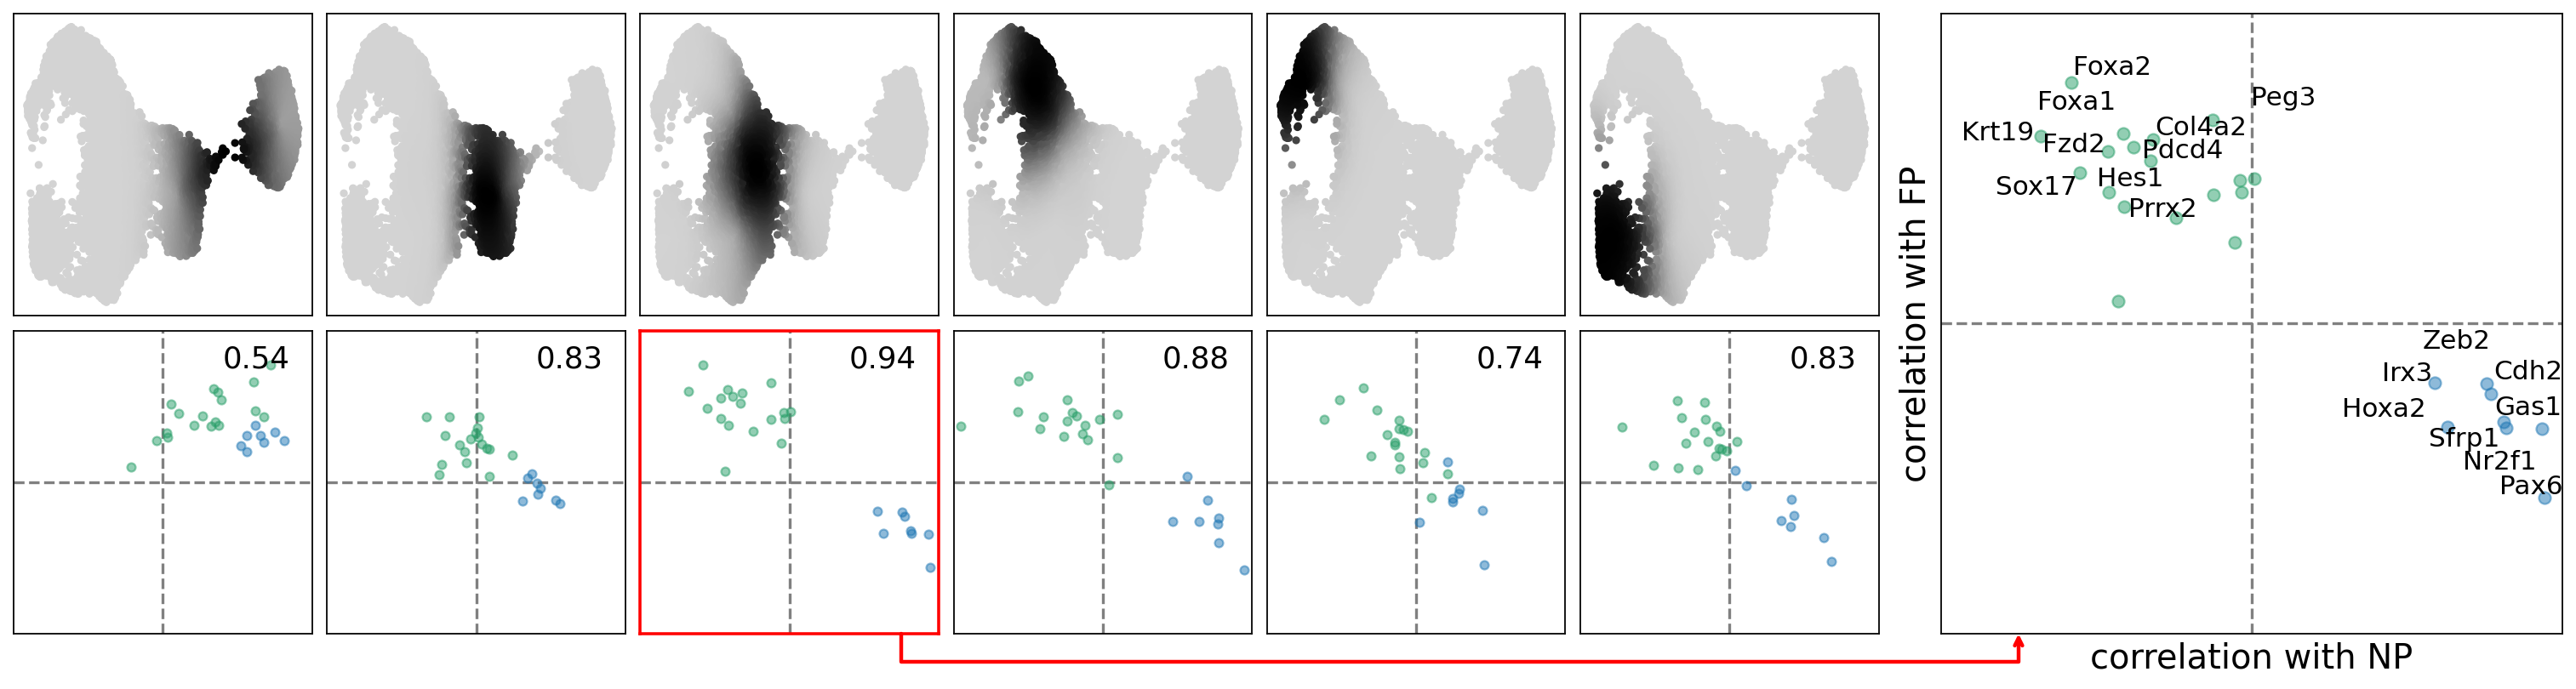

In [38]:
sc.set_figure_params()
scf.pl.slide_cors(adata,root_milestone="Root",milestones=["NP", "FP"],basis="umap", 
                 win_keep=[1, 2, 3, 4, 5,7],
                 focus=2, 
                 top_focus = 10, 
                 save="_H_save_v2.pdf")

In [28]:
# run magic from palantir
sc.pp.normalize_per_cell(adata)
palantir.preprocess.log_transform(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=500, flavor="cell_ranger")
sc.pp.pca(adata)
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(adata)
sc.pp.neighbors(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix 

In [29]:
imputed_X = palantir.utils.run_magic_imputation(adata)

In [30]:
imputed_X

matrix([[0.62940178, 1.37454759, 3.63612804, ..., 0.        , 0.        ,
         0.        ],
        [0.40655287, 1.35329557, 3.71482579, ..., 0.        , 0.        ,
         0.        ],
        [0.35348139, 1.31389189, 3.636055  , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.01634578, 0.09205188, 2.20559506, ..., 1.01246208, 0.46181628,
         0.01099602],
        [0.        , 0.11019176, 2.01985361, ..., 0.72706816, 0.85185636,
         0.01928666],
        [0.15271242, 0.45198808, 2.26778283, ..., 0.41360109, 0.09903774,
         0.02073881]])

In [31]:
df = pd.DataFrame(imputed_X)

In [32]:
df.columns = adata.var_names
df.index = adata.obs_names

In [33]:
df

Sox17     Sulf1     Terf1    Pou3f3  \
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1  0.629402  1.374548  3.636128  0.016006   
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1  0.406553  1.353296  3.714826  0.018905   
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1  0.353481  1.313892  3.636055  0.032550   
AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1  0.455160  1.433667  3.741257  0.023621   
AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1  0.389415  1.180591  3.659645  0.019475   
...                                    ...       ...       ...       ...   
TTTGGTTCACGACAGA-1_2_1            0.052922  0.152410  2.096628  2.053671   
TTTGGTTGTTAAGCAA-1_2_1            0.035728  1.743762  2.018270  0.662141   
TTTGGTTTCCCTCATG-1_2_1            0.016346  0.092052  2.205595  2.786762   
TTTGTTGAGACCATGG-1_2_1            0.000000  0.110192  2.019854  2.935814   
TTTGTTGCACGACCTG-1_2_1            0.152712  0.451988  2.267783  1.206857   

                                     Wdr12       Fn1  Serpine2      Cul3  \
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1  2.604211  1.417231  1.291826  2.578954   
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1  2.528998  1.369676  1.404490  2.469713   
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1  2.267207  1.355571  1.447039  2.456892   
AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1  2.573704  1.446848  1.406000  2.584124   
AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1  2.388513  1.069857  1.306490  2.361569   
...                                    ...       ...       ...       ...   
TTTGGTTCACGACAGA-1_2_1            2.868740  1.340698  2.726789  2.535721   
TTTGGTTGTTAAGCAA-1_2_1            1.564201  2.124578  1.466082  2.527580   
TTTGGTTTCCCTCATG-1_2_1            2.619730  1.076369  2.843702  2.464232   
TTTGTTGAGACCATGG-1_2_1            2.300549  1.064032  2.592524  2.264940   
TTTGTTGCACGACCTG-1_2_1            2.862263  1.691137  2.619967  2.826523   

                                     Kdm5b      Pbx1  ...      Pax3     Hoxa5  \
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1  3.338900  3.391187  ...  0.046707  1.985981   
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1  3.429382  3.263089  ...  0.021419  2.127158   
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1  3.529980  3.244993  ...  0.025924  1.958955   
AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1  3.485314  3.328369  ...  0.020194  1.994209   
AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1  3.386730  3.075411  ...  0.036342  1.897825   
...                                    ...       ...  ...       ...       ...   
TTTGGTTCACGACAGA-1_2_1            2.292735  3.089032  ...  1.628959  0.603541   
TTTGGTTGTTAAGCAA-1_2_1            2.767107  3.340878  ...  0.094570  0.522885   
TTTGGTTTCCCTCATG-1_2_1            2.204615  2.975213  ...  0.762659  0.321944   
TTTGTTGAGACCATGG-1_2_1            2.148462  2.896111  ...  0.386492  0.149694   
TTTGTTGCACGACCTG-1_2_1            2.634323  3.348268  ...  1.524337  0.904325   

                                     Nr2f2     Hoxb2     Hoxb1       Shh  \
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1  0.141358  1.767299  1.865361  0.000000   
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1  0.093176  1.804894  1.929057  0.000000   
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1  0.091132  1.300178  1.569383  0.000000   
AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1  0.089732  1.464054  1.686919  0.000000   
AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1  0.075508  1.359185  1.621803  0.000000   
...                                    ...       ...       ...       ...   
TTTGGTTCACGACAGA-1_2_1            2.074020  1.645827  0.176984  0.035156   
TTTGGTTGTTAAGCAA-1_2_1            2.718096  1.627980  0.049341  2.588413   
TTTGGTTTCCCTCATG-1_2_1            2.244070  1.433133  0.053838  0.089871   
TTTGTTGAGACCATGG-1_2_1            2.214824  1.506744  0.031606  0.120328   
TTTGTTGCACGACCTG-1_2_1            2.082731  1.713761  0.333934  0.071156   

                                    Nkx6-1      Dbx1     Olig2       Arx  
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1  0.000000  0.000000  0.000000  0.000000  
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1  0.000000  0.000000  0.000000  0.000000  
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1  0.000000  0.000000  0.000000  0.000000  
AAACGCTCAGAGTAAT-1_1_1_1_

In [34]:
df.to_csv(os.path.join(outDir, "annData_magic_impuated.csv"), index=True, header=True)

In [14]:
df = adata.to_df(layer="fitted")

In [15]:
df.to_csv(os.path.join(outDir, "annData_layer_fitted.csv"), index=True, header=True)

In [21]:
df = adata.obs[["t", 'seg', 't_sd', 'milestones']]

In [22]:
df.to_csv(os.path.join(outDir, "annData_pseudotime_segments_milestones.csv"), index=True, header=True)

In [25]:
scf.tl.slide_cells(adata,root_milestone="Root",milestones=["NP", "FP"], win=1500, copy = False) 

--> added 
    .uns['Root->NP<>FP']['cell_freq'], probability assignment of cells on 8 non intersecting windows.


In [26]:
adata

AnnData object with n_obs × n_vars = 10000 × 190
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'Root->NP<>FP', 'condition_colors', 'dendro_segments', 'draw_graph', 'graph', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_seurat_pca', 'X_seurat_umap', 'X_umap'
    varm: 'PCs'
    layers: 'fitted'
    obsp: 'connectivities', 'distances'

In [39]:
df = adata.uns['Root->NP<>FP']['cell_freq']

In [40]:
df = pd.DataFrame(df)

In [41]:
df

AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1  AAACGAACATTGCTGA-1_1_1_1_1_1_1_1  \
0                      8.078261e-01                      8.228927e-01   
1                      2.511633e-01                      2.356795e-01   
2                      3.281114e-04                      2.460086e-04   
3                      1.412424e-05                      1.024558e-05   
4                      1.338286e-06                      9.389617e-07   
5                      2.559793e-08                      1.781636e-08   
6                      1.072189e-06                      7.867645e-07   
7                      2.620680e-08                      1.910567e-08   

   AAACGAAGTATCGATC-1_1_1_1_1_1_1_1  AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1  \
0                      5.253173e-01                      8.117667e-01   
1                      5.241792e-01                      2.481931e-01   
2                      2.493320e-03                      2.347646e-04   
3                      7.275528e-05                      8.979428e-06   
4                      3.323979e-06                      7.010347e-07   
5                      4.920322e-08                      1.238109e-08   
6                      7.275949e-06                      7.187286e-07   
7                      1.686848e-07                      1.716468e-08   

   AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1  AAAGAACGTAATACCC-1_1_1_1_1_1_1_1  \
0                      5.857294e-01                      2.948452e-01   
1                      4.722307e-01                      7.271210e-01   
2                      6.171672e-04                      8.159360e-03   
3                      2.046901e-05                      2.663790e-04   
4                      1.215381e-06                      1.445011e-05   
5                      1.935837e-08                      2.211131e-07   
6                      1.793978e-06                      2.370802e-05   
7                      4.195433e-08                      5.539453e-07   

   AAAGAACTCATCCTAT-1_1_1_1_1_1_1_1  AAAGGATCAACCACGC-1_1_1_1_1_1_1_1  \
0                      8.446152e-01                      8.416755e-01   
1                      2.136278e-01                      2.171968e-01   
2                      1.338602e-04                      1.353583e-04   
3                      4.622314e-06                      4.509615e-06   
4                      3.139388e-07                      2.890563e-07   
5                      5.322472e-09                      4.812910e-09   
6                      3.920490e-07                      3.926267e-07   
7                      9.209370e-09                      9.178413e-09   

   AAAGGGCCAAATGGTA-1_1_1_1_1_1_1_1  AAAGGGCCACAGCTTA-1_1_1_1_1_1_1_1  ...  \
0                      8.095845e-01                      8.145826e-01  ...   
1                      2.533128e-01                      2.470662e-01  ...   
2                      1.885204e-04                      1.943917e-04  ...   
3                      5.928926e-06                      5.985188e-06  ...   
4                      3.333160e-07                      3.261745e-07  ...   
5                      5.284317e-09                      5.140694e-09  ...   
6                      5.434197e-07                      5.610307e-07  ...   
7                      1.263244e-08                      1.302016e-08  ...   

   TTTGACTGTAGCTGAG-1_2_1  TTTGACTTCCGATGTA-1_2_1  TTTGACTTCCTCTGCA-1_2_1  \
0            3.281935e-07            4.716855e-09            1.996230e-08   
1            2.649383e-04            6.672715e-06            9.171352e-06   
2            2.358320e-03            6.120812e-05            7.208425e-05   
3            1.695640e-01            3.403565e-03            5.017601e-03   
4            6.403707e-01            2.537386e-03            2.639603e-01   
5            1.242051e-01            3.421137e-03            8.076601e-01   
6            9.062962e-02            2.995352e-02            2.036577e-03   
7            4.389258e-02            9.688140e-01   

In [42]:
df.to_csv(os.path.join(outDir, "annData_cellAssignment_to_nonIntersectingWindows_8.csv"), index=True, header=True)

In [40]:
freq

[AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1    8.078261e-01
 AAACGAACATTGCTGA-1_1_1_1_1_1_1_1    8.228927e-01
 AAACGAAGTATCGATC-1_1_1_1_1_1_1_1    5.253173e-01
 AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1    8.117667e-01
 AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1    5.857294e-01
                                         ...     
 TTTGGTTCACGACAGA-1_2_1              3.331720e-07
 TTTGGTTGTTAAGCAA-1_2_1              4.544440e-09
 TTTGGTTTCCCTCATG-1_2_1              1.213461e-07
 TTTGTTGAGACCATGG-1_2_1              7.980709e-09
 TTTGTTGCACGACCTG-1_2_1              2.987568e-06
 Length: 10000, dtype: float64,
 AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1    0.251163
 AAACGAACATTGCTGA-1_1_1_1_1_1_1_1    0.235679
 AAACGAAGTATCGATC-1_1_1_1_1_1_1_1    0.524179
 AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1    0.248193
 AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1    0.472231
                                       ...   
 TTTGGTTCACGACAGA-1_2_1              0.000103
 TTTGGTTGTTAAGCAA-1_2_1              0.000006
 TTTGGTTTCCCTCATG-1_2_1              0.000050
 TTT

In [41]:
df = pd.DataFrame(freq)

In [43]:
df.to_csv(os.path.join(outDir, "freq_slideCelloutput_d2_d5.csv"), index=False, header=False)

In [48]:
## with known genes

In [34]:
scf.tl.slide_cors(adata,root_milestone="Root",milestones=["NP", "FP"], 
                  genesetA=['Foxa2', 'Shh'],
                  genesetB=['Pax6', 'Sox1']
                 )

--> added 
    .uns['Root->NP<>FP']['corAB'], gene-gene correlation modules.


In [35]:
adata.uns['Root->NP<>FP']['corAB']

{'NP': {'genesetA':               0         1         2         3         4         5         6  \
  Foxa2  0.007061  0.071674  0.050289  0.158031  0.179973  0.256082  0.142855   
  Shh    0.007061  0.071674  0.050289  0.158031  0.179973  0.256082  0.142855   
  
                7  
  Foxa2  0.275638  
  Shh    0.275638  ,
  'genesetB':              0         1         2         3         4         5         6  \
  Pax6  0.037997  0.042557 -0.040527 -0.174763 -0.157385 -0.265282 -0.174868   
  Sox1  0.010015  0.008687 -0.045356 -0.112038 -0.055378 -0.091640 -0.088900   
  
               7  
  Pax6 -0.116512  
  Sox1 -0.026797  },
 'FP': {'genesetA':               0         1         2         3         4         5         6  \
  Foxa2  0.047891  0.054999 -0.063629 -0.194228 -0.158261 -0.265800 -0.171476   
  Shh    0.000121 -0.003755 -0.022254 -0.092572 -0.054502 -0.091121 -0.092292   
  
                7  
  Foxa2 -0.093901  
  Shh   -0.049407  ,
  'genesetB':              0        

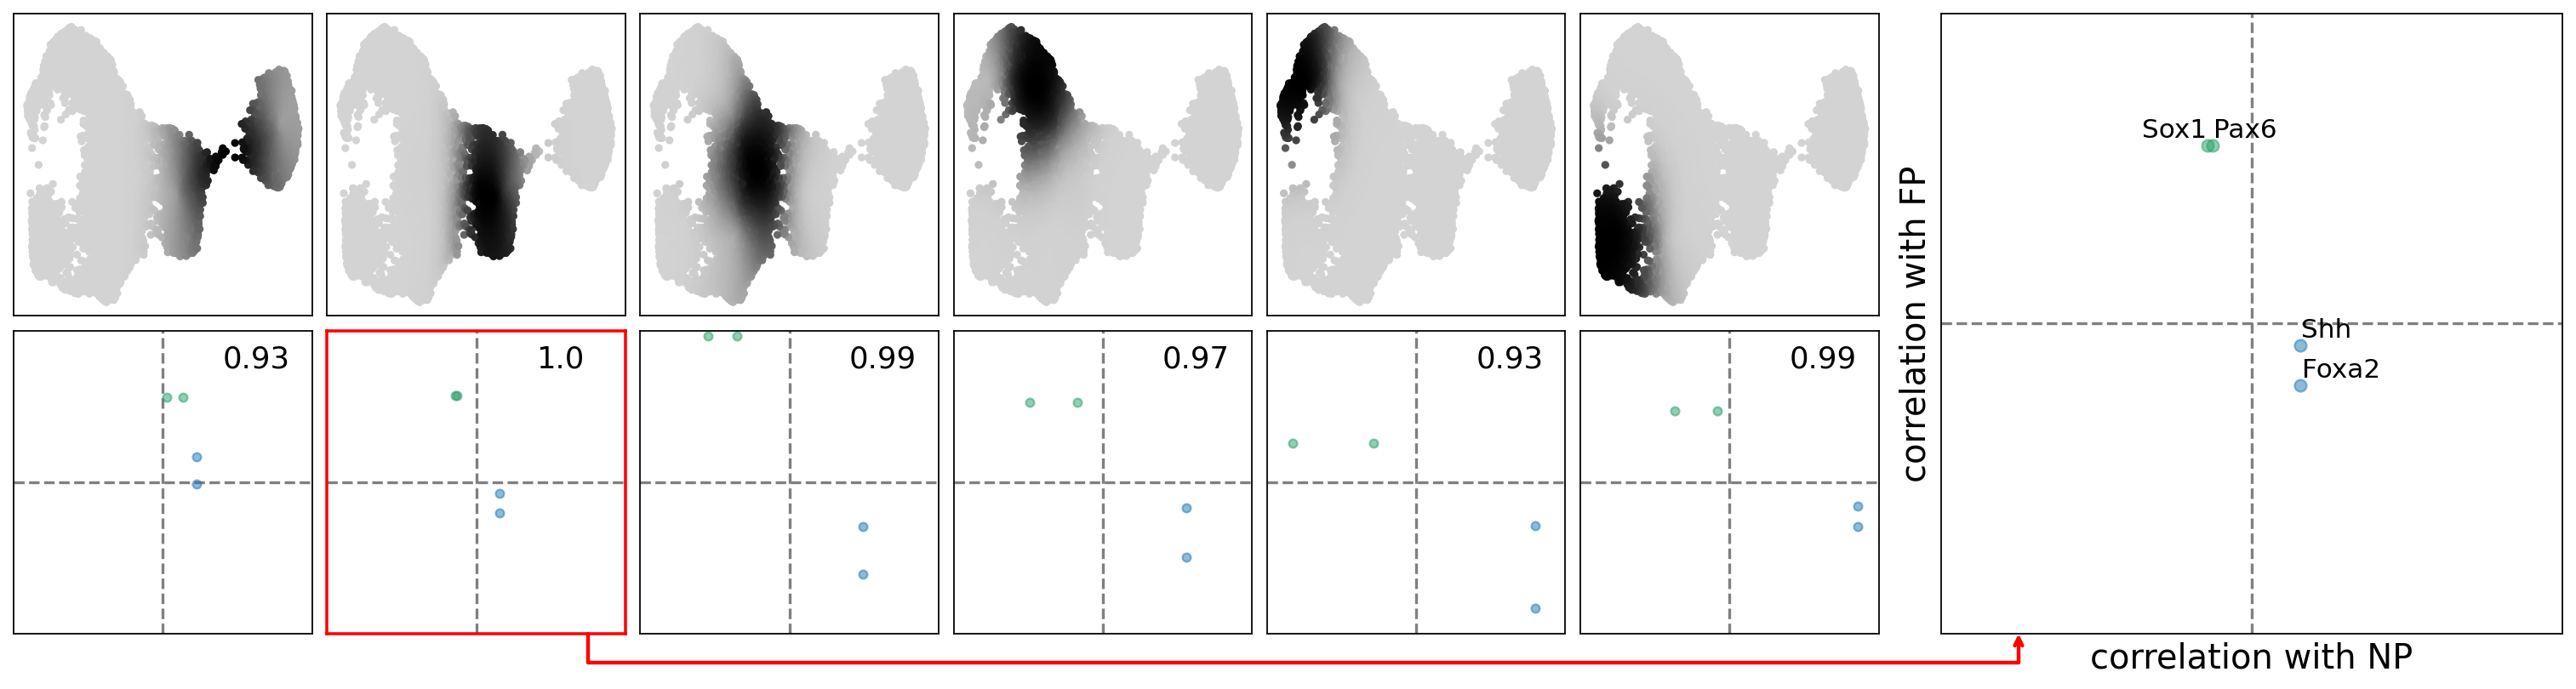

In [36]:
sc.set_figure_params()
scf.pl.slide_cors(adata,root_milestone="Root",milestones=["NP", "FP"],basis="umap", 
                  genesetA=['Foxa2', 'Shh'],
                  genesetB=['Pax6', 'Sox1'],
                 win_keep=[1, 2, 3, 4, 5,7],
                 focus=1, 
                  #top_focus = 10, 
                  save="_H_example.pdf")

In [ ]:
# MAGIC imputation with the full gene list

In [9]:
adata = sc.read_h5ad(os.path.join(outDir, 'RNAmatrix_RA_allGenes_d2.5_d5_regressed.CellCycle_v1.h5ad'),chunk_size=6000)

In [10]:
adata

AnnData object with n_obs × n_vars = 10000 × 20366
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.7', 'clusters', 'time', 'dataset'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [11]:
# run magic from palantir
sc.pp.normalize_per_cell(adata)
palantir.preprocess.log_transform(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger")
sc.pp.pca(adata)
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(adata)
sc.pp.neighbors(adata)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:32)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [12]:
imputed_X = palantir.utils.run_magic_imputation(adata)

In [13]:
imputed_X

matrix([[0.01833408, 0.01004962, 0.01258566, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.0127705 , 0.01045334, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.01424388, 0.01981813, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [14]:
df = pd.DataFrame(imputed_X)

In [18]:
adata.obs_names;
adata.var_names

Index(['Xkr4', 'Gm37180', 'Gm37363', 'Gm38148', 'Gm19938', 'Sox17', 'Gm6123',
       'Mrpl15', 'Gm37144', 'Lypla1',
       ...
       'Gm11653', 'Fam81b', 'Nkx2-1', 'Gm26744', 'Upk1b', 'Gm10785', 'Pi16',
       'H2-T-ps', 'BC023719', 'Tmc1'],
      dtype='object', length=20366)

In [15]:
df

0         1         2         3         4         5         6      \
0     0.018334  0.010050  0.012586  0.019834  0.093897  0.636486  0.022278   
1     0.000000  0.000000  0.000000  0.000000  0.077268  0.511579  0.015177   
2     0.012770  0.010453  0.000000  0.012219  0.060655  0.337444  0.026457   
3     0.011327  0.000000  0.016776  0.013541  0.066788  0.612980  0.017906   
4     0.000000  0.016434  0.000000  0.000000  0.080381  0.155021  0.020860   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.000000  0.011733  0.000000  0.000000  0.025042  0.031049  0.011403   
9996  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.036485   
9997  0.000000  0.014244  0.019818  0.000000  0.040601  0.021754  0.022499   
9998  0.000000  0.000000  0.000000  0.017849  0.000000  0.000000  0.000000   
9999  0.000000  0.000000  0.000000  0.000000  0.010103  0.081863  0.000000   

         7         8         9      ...  20356  20357  20358  20359  20360  \
0     3.495599  0.000000  1.669952  ...    0.0    0.0    0.0    0.0    0.0   
1     3.547969  0.000000  1.519234  ...    0.0    0.0    0.0    0.0    0.0   
2     3.580995  0.000000  1.656903  ...    0.0    0.0    0.0    0.0    0.0   
3     3.566516  0.000000  1.570438  ...    0.0    0.0    0.0    0.0    0.0   
4     3.333675  0.000000  1.341661  ...    0.0    0.0    0.0    0.0    0.0   
...        ...       ...       ...  ...    ...    ...    ...    ...    ...   
9995  3.346425  0.000000  1.459568  ...    0.0    0.0    0.0    0.0    0.0   
9996  2.649886  0.000000  1.233934  ...    0.0    0.0    0.0    0.0    0.0   
9997  3.275919  0.000000  1.672066  ...    0.0    0.0    0.0    0.0    0.0   
9998  3.027349  0.000000  1.117458  ...    0.0    0.0    0.0    0.0    0.0   
9999  3.206806  0.017931  1.479510  ...    0.0    0.0    0.0    0.0    0.0   

      20361  20362  20363  20364  20365  
0       0.0    0.0    0.0    0.0    0.0  
1       0.0    0.0    0.0    0.0    0.0  
2       0.0    0.0    0.0    0.0    0.0  
3       0.0    0.0    0.0    0.0    0.0  
4       0.0    0.0    0.0    0.0    0.0  
...     ...    ...    ...    ...    ...  
9995    0.0    0.0    0.0    0.0    0.0  
9996    0.0    0.0    0.0    0.0    0.0  
9997    0.0    0.0    0.0    0.0    0.0  
9998    0.0    0.0    0.0    0.0    0.0  
9999    0.0    0.0    0.0    0.0    0.0  

[10000 rows x 20366 columns]

In [19]:
df.columns = adata.var_names
df.index = adata.obs_names

In [20]:
df

Xkr4   Gm37180   Gm37363   Gm38148   Gm19938     Sox17    Gm6123  \
0     0.018334  0.010050  0.012586  0.019834  0.093897  0.636486  0.022278   
1     0.000000  0.000000  0.000000  0.000000  0.077268  0.511579  0.015177   
2     0.012770  0.010453  0.000000  0.012219  0.060655  0.337444  0.026457   
3     0.011327  0.000000  0.016776  0.013541  0.066788  0.612980  0.017906   
4     0.000000  0.016434  0.000000  0.000000  0.080381  0.155021  0.020860   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.000000  0.011733  0.000000  0.000000  0.025042  0.031049  0.011403   
9996  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.036485   
9997  0.000000  0.014244  0.019818  0.000000  0.040601  0.021754  0.022499   
9998  0.000000  0.000000  0.000000  0.017849  0.000000  0.000000  0.000000   
9999  0.000000  0.000000  0.000000  0.000000  0.010103  0.081863  0.000000   

        Mrpl15   Gm37144    Lypla1  ...  Gm11653  Fam81b  Nkx2-1  Gm26744  \
0     3.495599  0.000000  1.669952  ...      0.0     0.0     0.0      0.0   
1     3.547969  0.000000  1.519234  ...      0.0     0.0     0.0      0.0   
2     3.580995  0.000000  1.656903  ...      0.0     0.0     0.0      0.0   
3     3.566516  0.000000  1.570438  ...      0.0     0.0     0.0      0.0   
4     3.333675  0.000000  1.341661  ...      0.0     0.0     0.0      0.0   
...        ...       ...       ...  ...      ...     ...     ...      ...   
9995  3.346425  0.000000  1.459568  ...      0.0     0.0     0.0      0.0   
9996  2.649886  0.000000  1.233934  ...      0.0     0.0     0.0      0.0   
9997  3.275919  0.000000  1.672066  ...      0.0     0.0     0.0      0.0   
9998  3.027349  0.000000  1.117458  ...      0.0     0.0     0.0      0.0   
9999  3.206806  0.017931  1.479510  ...      0.0     0.0     0.0      0.0   

      Upk1b  Gm10785  Pi16  H2-T-ps  BC023719  Tmc1  
0       0.0      0.0   0.0      0.0       0.0   0.0  
1       0.0      0.0   0.0      0.0       0.0   0.0  
2       0.0      0.0   0.0      0.0       0.0   0.0  
3       0.0      0.0   0.0      0.0       0.0   0.0  
4       0.0      0.0   0.0      0.0       0.0   0.0  
...     ...      ...   ...      ...       ...   ...  
9995    0.0      0.0   0.0      0.0       0.0   0.0  
9996    0.0      0.0   0.0      0.0       0.0   0.0  
9997    0.0      0.0   0.0      0.0       0.0   0.0  
9998    0.0      0.0   0.0      0.0       0.0   0.0  
9999    0.0      0.0   0.0      0.0       0.0   0.0  

[10000 rows x 20366 columns]

In [24]:
df.index = adata.obs_names

In [25]:
df

Xkr4   Gm37180   Gm37363   Gm38148  \
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1  0.018334  0.010050  0.012586  0.019834   
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1  0.000000  0.000000  0.000000  0.000000   
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1  0.012770  0.010453  0.000000  0.012219   
AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1  0.011327  0.000000  0.016776  0.013541   
AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1  0.000000  0.016434  0.000000  0.000000   
...                                    ...       ...       ...       ...   
TTTGGTTCACGACAGA-1_2_1            0.000000  0.011733  0.000000  0.000000   
TTTGGTTGTTAAGCAA-1_2_1            0.000000  0.000000  0.000000  0.000000   
TTTGGTTTCCCTCATG-1_2_1            0.000000  0.014244  0.019818  0.000000   
TTTGTTGAGACCATGG-1_2_1            0.000000  0.000000  0.000000  0.017849   
TTTGTTGCACGACCTG-1_2_1            0.000000  0.000000  0.000000  0.000000   

                                   Gm19938     Sox17    Gm6123    Mrpl15  \
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1  0.093897  0.636486  0.022278  3.495599   
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1  0.077268  0.511579  0.015177  3.547969   
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1  0.060655  0.337444  0.026457  3.580995   
AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1  0.066788  0.612980  0.017906  3.566516   
AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1  0.080381  0.155021  0.020860  3.333675   
...                                    ...       ...       ...       ...   
TTTGGTTCACGACAGA-1_2_1            0.025042  0.031049  0.011403  3.346425   
TTTGGTTGTTAAGCAA-1_2_1            0.000000  0.000000  0.036485  2.649886   
TTTGGTTTCCCTCATG-1_2_1            0.040601  0.021754  0.022499  3.275919   
TTTGTTGAGACCATGG-1_2_1            0.000000  0.000000  0.000000  3.027349   
TTTGTTGCACGACCTG-1_2_1            0.010103  0.081863  0.000000  3.206806   

                                   Gm37144    Lypla1  ...  Gm11653  Fam81b  \
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1  0.000000  1.669952  ...      0.0     0.0   
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1  0.000000  1.519234  ...      0.0     0.0   
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1  0.000000  1.656903  ...      0.0     0.0   
AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1  0.000000  1.570438  ...      0.0     0.0   
AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1  0.000000  1.341661  ...      0.0     0.0   
...                                    ...       ...  ...      ...     ...   
TTTGGTTCACGACAGA-1_2_1            0.000000  1.459568  ...      0.0     0.0   
TTTGGTTGTTAAGCAA-1_2_1            0.000000  1.233934  ...      0.0     0.0   
TTTGGTTTCCCTCATG-1_2_1            0.000000  1.672066  ...      0.0     0.0   
TTTGTTGAGACCATGG-1_2_1            0.000000  1.117458  ...      0.0     0.0   
TTTGTTGCACGACCTG-1_2_1            0.017931  1.479510  ...      0.0     0.0   

                                  Nkx2-1  Gm26744  Upk1b  Gm10785  Pi16  \
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1     0.0      0.0    0.0      0.0   0.0   
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1     0.0      0.0    0.0      0.0   0.0   
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1     0.0      0.0    0.0      0.0   0.0   
AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1     0.0      0.0    0.0      0.0   0.0   
AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1     0.0      0.0    0.0      0.0   0.0   
...                                  ...      ...    ...      ...   ...   
TTTGGTTCACGACAGA-1_2_1               0.0      0.0    0.0      0.0   0.0   
TTTGGTTGTTAAGCAA-1_2_1               0.0      0.0    0.0      0.0   0.0   
TTTGGTTTCCCTCATG-1_2_1               0.0      0.0    0.0      0.0   0.0   
TTTGTTGAGACCATGG-1_2_1               0.0      0.0    0.0      0.0   0.0   
TTTGTTGCACGACCTG-1_2_1               0.0      0.0    0.0      0.0   0.0   

                                  H2-T-ps  BC023719  Tmc1  
AAACCCATCGAGGCAA-1_1_1_1_1_1_1_1      0.0       0.0   0.0  
AAACGAACATTGCTGA-1_1_1_1_1_1_1_1      0.0       0.0   0.0  
AAACGAAGTATCGATC-1_1_1_1_1_1_1_1      0.0       0.0   0.0  
AAACGCTCAGAGTAAT-1_1_1_1_1_1_1_1      0.0       0.0   0.0  
AAAGAACAGCAACAGC-1_1_1_1_1_1_1_1      0.0       0.0   0.0  
...           

In [26]:
df.to_csv(os.path.join(outDir, "annData_magic_impuated_allGenes.csv"), index=True, header=True)